In [1]:
from PIL import Image
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pandas as pd
import math
import shutil
# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)

C:\Users\ciarp\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Impossibile trovare la procedura specificata'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [ ]:
# from zipfile import ZipFile
# with ZipFile('/content/drive/MyDrive/archive/data/yolov1/yolov1-20231017T090248Z-002.zip', 'r') as f:
#    f.extractall('/content/drive/MyDrive/archive/data')

In [2]:
# Drive Path
# import zipfile
# with zipfile.ZipFile(os.path.join(os.getcwd(),"drive","MyDrive","archive (1).zip"), 'r') as zip_ref:
#     zip_ref.extractall(os.path.join(os.getcwd(),"drive","MyDrive","archive"))

#drive_dir=os.path.join(os.getcwd(),"drive","MyDrive","archive","data")
# drive_dir=os.path.join(os.getcwd(),"drive","MyDrive","archive","data")
drive_dir=os.path.join(os.getcwd(), "archive","data")


#Dataframe Creation
train_labels=os.path.join(drive_dir,"train_solution_bounding_boxes (1).csv")

train_imgs_dir=os.path.join(drive_dir,"training_images")
test_imgs_dir=os.path.join(drive_dir,"testing_images")

imgs_list=list(sorted(os.listdir(train_imgs_dir)))
idxs=list(range(len(imgs_list)))
np.random.shuffle(idxs)

train_idx=idxs[:int(0.8*len(idxs))]
val_idx=idxs[int(0.8*len(idxs)):]


imgs_list=list(sorted(os.listdir(train_imgs_dir)))

In [ ]:
df=pd.read_csv(train_labels)

width=676
height=380

df["class"]=0
df.rename(columns={'image':'img_name'}, inplace=True)

df["x_centre"]=(df["xmin"]+df["xmax"])/2
df["y_centre"]=(df["ymin"]+df["ymax"])/2
df["width"]=(df["xmax"]-df["xmin"])
df["height"]=(df["ymax"]-df["ymin"])

#normalizing bounding box coordinates
df["x_centre"]=df["x_centre"]/width
df["y_centre"]=df["y_centre"]/height
df["width"]=df["width"]/width
df["height"]=df["height"]/height

df_yolo=df[["img_name","class","x_centre","y_centre","width","height"]]
df_yolo.head()

,img_name,class,x_centre,y_centre,width,height
0,vid_4_1000.jpg,0,0.450434,0.539817,0.068741,0.095238
1,vid_4_10000.jpg,0,0.100217,0.557191,0.155572,0.129987
2,vid_4_10040.jpg,0,0.444645,0.543678,0.181621,0.157014
3,vid_4_10020.jpg,0,0.833213,0.531451,0.197540,0.155727
4,vid_4_10060.jpg,0,0.110347,0.559122,0.171491,0.136422


In [3]:
# train and test subdirectories with labels directory

from os import path
yolo_dir=os.path.join(drive_dir,"yolov8")
if path.exists(yolo_dir) == False:
  os.mkdir(yolo_dir)

labels_dir=os.path.join(yolo_dir,"labels")
if path.exists(labels_dir) == False:
  os.mkdir(labels_dir)

if path.exists(labels_dir+"/train") == False:
  os.mkdir(labels_dir+"/train")
if path.exists(labels_dir+"/val") == False:
  os.mkdir(labels_dir+"/val")

images_dir=os.path.join(yolo_dir,"images")
if path.exists(images_dir) == False:
  os.mkdir(images_dir)

if path.exists(images_dir+"/train") == False:
  os.mkdir(images_dir+"/train")
if path.exists(images_dir+"/val") == False:
  os.mkdir(images_dir+"/val")

# for idx,img_name in enumerate(imgs_list):
#     subset="train"
#     if idx in val_idx:
#         subset="val"

#     if np.isin(img_name,df_yolo["img_name"]):
#         columns=["class","x_centre","y_centre","width","height"]
#         img_bbox=df_yolo[df_yolo["img_name"]==img_name][columns].values

#         label_file_path=os.path.join(labels_dir,subset,img_name[:-4]+".txt")
#         with open(label_file_path,"w+") as f:
#             for row in img_bbox:
#                 text=" ".join(row.astype(str))
#                 f.write(text)
#                 f.write("\n")

#     old_image_path=os.path.join(train_imgs_dir,img_name)
#     new_image_path=os.path.join(images_dir,subset,img_name)
#     shutil.copy(old_image_path,new_image_path)


In [ ]:
import yaml
yolo_format=dict(path=yolo_dir,
                 train=images_dir+"/train",
                 val=images_dir+"/val",
                 nc=1,
                 names={0:"car"})

with open(yolo_dir+'/yolo.yaml', 'w') as outfile:
    yaml.dump(yolo_format, outfile, default_flow_style=False)

In [ ]:
!pip install ultralytics
from ultralytics import YOLO
model=YOLO('yolov8m.pt')
model.train(data=yolo_dir+'/yolo.yaml',epochs=1,patience=5,batch=8,
                     lr0=0.0005,imgsz=640)

In [ ]:
path_best_weights="/content/runs/detect/train/weights/best.pt"
model = YOLO(path_best_weights)

metrics = model.val()

In [ ]:
with torch.no_grad():
    results=model.predict(source=test_imgs_dir,conf=0.50,iou=0.75)

In [ ]:
prediction_dir=os.path.join(yolo_dir,"predictions")
if path.exists(prediction_dir) == False:
  os.mkdir(prediction_dir)

In [ ]:
test_img_list=[]
for result in results:
    if len(result.boxes.xyxy):
        name=result.path.split("/")[-1].split(".")[0]
        boxes=result.boxes.xyxy.cpu().numpy()
        scores=result.boxes.conf.cpu().numpy()

        test_img_list.append(name)

        label_file_path=os.path.join(prediction_dir,name+".txt")
        with open(label_file_path,"w+") as f:
            for score,box in zip(scores,boxes):
                text=f"{score:0.4f} "+" ".join(box.astype(str))
                f.write(text)
                f.write("\n")

In [ ]:
def show_bbox(img,boxes,scores,name,axis=0,color=(0,255,0)):
    boxes=boxes.astype(int)
    scores=scores
    img=img.copy()
    for i,box in enumerate(boxes):
        score=f"{scores[i]:.4f}"
        cv2.rectangle(img,(box[0],box[1]),(box[2],box[3]),color,2)
        y=box[1]-10 if box[1]-10>10 else box[1]+10
        cv2.putText(img,score,(box[0],y),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)
    plt.imshow(img)
    plt.savefig(name+".png")
    #axis.imshow(img)
    #axis.axis("off")

In [ ]:
fig,axes=plt.subplots(1,1,figsize=(12,12))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
#ax=axes.flatten()

imgs_name=np.random.choice(test_img_list,15)
#imgs_name=['vid_5_400','vid_5_25100']
for i,img_name in enumerate(imgs_name):
    img_file_path=os.path.join(test_imgs_dir,img_name+".jpg")
    img=cv2.imread(img_file_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    label_file_path=os.path.join(prediction_dir,img_name+".txt")
    label=pd.read_csv(label_file_path,sep=" ",header=None).values
    scores=label[:,0]
    boxes=label[:,1:]
    show_bbox(img,boxes,scores,name=img_name+"_yolov8")

plt.savefig("1.png")

In [4]:
import torch
import torch.nn as nn
import torchvision.transforms.v2 as transforms

import torch.optim as optim
import torchvision.transforms.functional as FT
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import subprocess
import os
from PIL import Image
import time
from tqdm import tqdm

from IPython import display
display.clear_output()

from torchvision import datapoints

# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)

In [5]:
# from os import path
# drive_dir=os.path.join(os.getcwd(),"drive","MyDrive","archive","data")
#drive_dir=os.path.join(os.getcwd(),"drive","MyDrive","data")


yolo_dir=os.path.join(drive_dir,"yolov8")
if path.exists(yolo_dir) == False:
  os.mkdir(yolo_dir)

labels_dir=os.path.join(yolo_dir,"labels")
if path.exists(labels_dir) == False:
  os.mkdir(labels_dir)

if path.exists(labels_dir+"/train") == False:
  os.mkdir(labels_dir+"/train")
if path.exists(labels_dir+"/val") == False:
  os.mkdir(labels_dir+"/val")

images_dir=os.path.join(yolo_dir,"images")
if path.exists(images_dir) == False:
  os.mkdir(images_dir)

if path.exists(images_dir+"/train") == False:
  os.mkdir(images_dir+"/train")
if path.exists(images_dir+"/val") == False:
  os.mkdir(images_dir+"/val")

In [6]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Calculates intersection over union
    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, S, S, 4) #4 because only 1 box is passed per time
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, S, S, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)
    Returns:
        tensor: Intersection over union for all examples
    """

    # print("boxes_preds: ", boxes_preds.shape)
    # print("boxes_labels: ", boxes_labels.shape)

    if box_format == "midpoint" :
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2  # x - (w / 2)
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2  # y - (h / 2)
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2  # x + (w / 2)
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2  # y + (h / 2)

        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners" :
        box1_x1, box1_y1 = boxes_preds[..., 0:1], boxes_preds[..., 1:2]
        box1_x2, box1_y2 = boxes_preds[..., 2:3], boxes_preds[..., 3:4]
        box2_x1, box2_y1 = boxes_labels[..., 0:1], boxes_labels[..., 1:2]
        box2_x2, box2_y2 = boxes_labels[..., 2:3], boxes_labels[..., 3:4]

    x1, y1 = torch.max(box1_x1, box2_x1), torch.max(box1_y1, box2_y1) #greater upper-left corner
    x2, y2 = torch.min(box1_x2, box2_x2), torch.min(box1_y2, box2_y2) #lower bottom-right corner


    '''
    limits the range to a lower bound of 0, so to avoid negative values.
    inter computes the area, how?
    '''

    inter = (x2-x1).clamp(0) * (y2-y1).clamp(0)

    box1_area = abs( (box1_x2 - box1_x1) * (box1_y2 - box1_y1) ) #base * altezza
    box2_area = abs( (box2_x2 - box2_x1) * (box2_y2 - box2_y1) )

    uni = box1_area + box2_area - inter

    return inter / (uni + 1e-6)


def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes
    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU)
        box_format (str): "midpoint" or "corners" used to specify bboxes
    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):
    """
    Calculates mean average precision
    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes
    Returns:
        float: mAP value across all classes given a specific IoU threshold
    """

    avg_precisions = []
    epsilon = 1e-6 # used for numerical stability
    for c in range(num_classes):
        detections, ground_truths = [], []
        for detection in pred_boxes:
            if detection[1] == c: detections.append(detection)
        for true_box in true_boxes :
            if true_box[1] == c: ground_truths.append(true_box)
        amount_bboxes = Counter([gt[0] for gt in ground_truths])
        for key,val in amount_bboxes.items(): amount_bboxes[key] = torch.zeros(val)
        detections.sort(key=lambda x:x[2], reverse=True)
        TP, FP, total_true_bboxes = torch.zeros(len(detections)), torch.zeros(len(detections)), len(ground_truths)
        if total_true_bboxes == 0:
            continue
        for detection_idx, detection in enumerate(detections):
            ground_truth_img = [ bbox for bbox in ground_truths if bbox[0] == detection[0] ]
            num_gts = len(ground_truth_img)
            best_iou = 0
            for idx, gt in enumerate(ground_truth_img) :
                iou = intersection_over_union(torch.tensor(detection[3:]), torch.tensor(gt[3:]), box_format=box_format,)
                if iou > best_iou :
                    best_iou = iou
                    best_gt_idx = idx
            if best_iou > iou_threshold :
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else :
                    FP[detection_idx] = 1
            else :
                FP[detection_idx] = 1
        TP_cumsum, FP_cumsum = torch.cumsum(TP, dim=0), torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions, recalls = torch.cat((torch.tensor([1]), precisions)), torch.cat((torch.tensor([0]), recalls))
        avg_precisions.append(torch.trapz(precisions, recalls))

    return sum(avg_precisions) / (len(avg_precisions) + epsilon)


def plot_image(image, boxes,color):
    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
    height, width, _ = im.shape
    fig, ax = plt.subplots(1)
    ax.imshow(im)
    for box in boxes:
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width, box[3] * height,
            linewidth=1, edgecolor=color, facecolor="none",
        )
        ax.add_patch(rect)
    plt.show()

def get_bboxes(loader, model, iou_threshold, threshold,S=7, B=2, C=1, pred_format="cells", box_format="midpoint", device="cuda"):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels,S,B,C)
        bboxes = cellboxes_to_boxes(predictions,S,B,C)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )
            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes



def convert_cellboxes(predictions, S=7,B=2, C=20):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios.
    """
    num_classes=C
    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, B*5+C)
    bboxes1 = predictions[..., num_classes+1:num_classes+5]
    bboxes2 = predictions[..., num_classes+6:num_classes+10]
    scores = torch.cat(
        (predictions[..., num_classes].unsqueeze(0), predictions[..., num_classes+5].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :num_classes].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., num_classes], predictions[..., num_classes+5]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds


def cellboxes_to_boxes(out, S=7,B=2, C=20):
    converted_pred = convert_cellboxes(out,S,B,C).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []
    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

def makeCSVfile(dataset, folder):
    images = subprocess.check_output("ls "+ dataset.location + folder + '/images', shell=True, text=True).split('\n')[:-1]
    labels = subprocess.check_output("ls "+ dataset.location + folder + '/labels', shell=True, text=True).split('\n')[:-1]
    return pd.DataFrame(data = {'image': images, 'text':labels})

def save_checkpoint(state, filename="my_checkpoint.pth.tar", exit_training=False):
    print("=> Saving checkpoint")
    torch.save(state, filename)
    if exit_training : exit()

def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [28]:
# Conv2d BatchNorm2d LeakyReLU MaxPool2d

import torch
import torch.nn as nn

architecture_config = [
    (7, 64, 2, 3),
    "M-2",
    (3, 192, 1, 1),
    "M-2",
    "D",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M-2",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M-2",
    "D",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]

class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels) # not present in the original YOLO model
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x): return self.leakyrelu(self.batchnorm(self.conv(x)))

class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super().__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)
        self.name='yolov1'

    def forward(self, x):
        x = self.darknet(x)
        # print(f'output shape: {x.shape}')
        return self.fcs(torch.flatten(x, start_dim=1))

    def _create_conv_layers(self, architecture):
        in_channels = self.in_channels
        layers = []
        for x in architecture:
            if type(x)==tuple:
                layers += [ CNNBlock(in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3]) ]
                in_channels = x[1]
            elif type(x)==str:
                layer_type = x.split("-")
        
                if layer_type[0] == "M":
                  stride = int(layer_type[1])
                  layers += [ nn.MaxPool2d(kernel_size=2, stride=stride) ]
                elif layer_type[0] == "BN":
                  layers += [ nn.BatchNorm2d(in_channels) ]
                elif layer_type[0] == "D":
                  layers += [ nn.Dropout2d(p=0.15) ]
            elif type(x)==list:
                conv1, conv2, num_repeats = x[0], x[1], x[2]
                for i in range(num_repeats):
                    layers += [ CNNBlock(in_channels, conv1[1], kernel_size=conv1[0], stride=conv1[2], padding=conv1[3]) ]
                    layers += [ CNNBlock(conv1[1], conv2[1], kernel_size=conv2[0], stride=conv2[2], padding=conv2[3]) ]
                    in_channels = conv2[1]
        return nn.Sequential(*layers)

    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024*S*S,496), #4096 in YOLO paper
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, S*S*(B*5+C))
        )

    def predict(self,split_size, num_boxes, num_classes, source,conf=0.50,iou=0.75):
      S, B, C = split_size, num_boxes, num_classes
      self.eval()
      torch.no_grad()

      test_img_list=list(sorted(os.listdir(source)))
      result={}
      for image in test_img_list:
        img_file_path=os.path.join(source,image)
        img = Image.open(img_file_path)
        for t in [transforms.Resize((448, 448)), transforms.ToTensor(),]:
          img = t(img)
        img=torch.unsqueeze(img, dim=0)
        img = img.to(DEVICE)
        bboxes = cellboxes_to_boxes(self(img),S=split_size,B=num_boxes, C=num_classes)
        bboxes = non_max_suppression(bboxes[0], iou_threshold=iou, threshold=conf, box_format="midpoint")
        result[image]=bboxes
      return result


In [8]:
architecture_config_tiny = [
    (3, 16, 1, 1),
    "M-2",
    (3, 32, 1, 1),
    "M-2",
    (3, 64, 1, 1),
    "M-2",
    (3, 128, 1, 1),
    "M-2",
    (3, 256, 1, 1),
    "M-2",
    (3, 512, 1, 1),
    "M-2",
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
    (1, 1024, 1, 0)
]

class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels) # not present in the original YOLO model
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x): return self.leakyrelu(self.batchnorm(self.conv(x)))

class Yolov2Tiny(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super().__init__()
        self.architecture = architecture_config_tiny
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)
        self.name='tiny_yolo'

    def forward(self, x):
        x = self.darknet(x)
        # print(f'output shape: {x.shape}')
        return self.fcs(torch.flatten(x, start_dim=1))

    def _create_conv_layers(self, architecture):
        in_channels = self.in_channels
        layers = []
        for x in architecture:
            if type(x)==tuple:
                layers += [ CNNBlock(in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3]) ]
                in_channels = x[1]
            elif type(x)==str:
                stride = int(x.split("-")[1])
                layers += [ nn.MaxPool2d(kernel_size=2, stride=stride) ]
            elif type(x)==list:
                conv1, conv2, num_repeats = x[0], x[1], x[2]
                for i in range(num_repeats):
                    layers += [ CNNBlock(in_channels, conv1[1], kernel_size=conv1[0], stride=conv1[2], padding=conv1[3]) ]
                    layers += [ CNNBlock(conv1[1], conv2[1], kernel_size=conv2[0], stride=conv2[2], padding=conv2[3]) ]
                    in_channels = conv2[1]
        return nn.Sequential(*layers)

    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024*S*S,496), #4096 in YOLO paper
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, S*S*(B*5+C))
        )
    def predict(self,split_size, num_boxes, num_classes, source,conf=0.50,iou=0.75):
      S, B, C = split_size, num_boxes, num_classes
      self.eval()
      torch.no_grad()

      test_img_list=list(sorted(os.listdir(source)))
      result={}
      for image in test_img_list:
        img_file_path=os.path.join(source,image)
        img = Image.open(img_file_path)
        for t in [transforms.Resize((448, 448)), transforms.ToTensor()]:#transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.3, 0.3, 0.3])]:
          img = t(img)
        img=torch.unsqueeze(img, dim=0)
        img = img.to(DEVICE)
        bboxes = cellboxes_to_boxes(self(img),S=split_size,B=num_boxes, C=num_classes)
        bboxes = non_max_suppression(bboxes[0], iou_threshold=iou, threshold=conf, box_format="midpoint")
        result[image]=bboxes
      return result

In [9]:
class YoloLossFruit(nn.Module):
    """
    Calculate the loss for yolo (v1) model
    """

    def __init__(self, S=7, B=2, C=3):
        super(YoloLossFruit, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S is split size of image (in paper 7),
        B is number of boxes (in paper 2),
        C is number of classes (in paper 20, in dataset 3),
        """
        self.S = S
        self.B = B
        self.C = C

        # These are from Yolo paper, signifying how much we should
        # pay loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # predictions are shaped (BATCH_SIZE, S*S(C+B*5) when inputted
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_b1 = intersection_over_union(predictions[..., self.C + 1:self.C + 5], target[..., self.C + 1:self.C + 5])
        iou_b2 = intersection_over_union(predictions[..., self.C + 6:self.C + 10], target[..., self.C + 1:self.C + 5])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # Take the box with highest IoU out of the two prediction
        # Note that bestbox will be indices of 0, 1 for which bbox was best
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., self.C].unsqueeze(3)  # in paper this is Iobj_i

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out one of the two
        # predictions, which is the one with highest Iou calculated previously.
        box_predictions = exists_box * (
            (
                bestbox * predictions[..., self.C + 6:self.C + 10]
                + (1 - bestbox) * predictions[..., self.C + 1:self.C + 5]
            )
        )

        box_targets = exists_box * target[..., self.C + 1:self.C + 5]

        # Take sqrt of width, height of boxes to ensure that
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_box = (
            bestbox * predictions[..., self.C + 5:self.C + 6] + (1 - bestbox) * predictions[..., self.C:self.C + 1]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., self.C:self.C + 1]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        #max_no_obj = torch.max(predictions[..., 20:21], predictions[..., 25:26])
        #no_object_loss = self.mse(
        #    torch.flatten((1 - exists_box) * max_no_obj, start_dim=1),
        #    torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        #)

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., self.C:self.C + 1], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., self.C:self.C + 1], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., self.C + 5:self.C + 6], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., self.C:self.C + 1], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :self.C], end_dim=-2,),
            torch.flatten(exists_box * target[..., :self.C], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss

In [10]:
class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")
        self.S, self.B, self.C = S, B, C
        self.lambda_coord, self.lambda_noobj = 5, .5

    def forward(self, predictions, target ):
        predictions = predictions.reshape(-1, self.S, self.S, self.B*5+self.C)
        ious = torch.cat(
            (intersection_over_union(predictions[...,self.C+1:self.C+5], target[...,self.C+1:self.C+5]).unsqueeze(0),  #unsqueeze(0) works only if b_size == 1
            intersection_over_union(predictions[...,self.C+6:self.C+10], target[...,self.C+1:self.C+5]).unsqueeze(0)) # target = [1, 1, x, y, w, h, 0,0,0,0,0]
                                                                                                                      #pred = [0.8, 0, 0.6, 0.8, 0.5, 0.7, 1, 0.5, 0.4,
        )

        '''
            CASE 1 CLASS:
            C+1:C+5 -> 2:6 (4) ELEMENTS
            C+6:C+10 -> 7:11 (4) ELEMENTS
            element in position [C+5] is excluded
        '''

        _, bestbox = torch.max(ious, dim=0)
        exists_box = target[...,self.C:self.C+1]

        box_predictions =  exists_box * ( (1-bestbox)*predictions[...,self.C+1:self.C+5] + bestbox*predictions[...,self.C+6:self.C+10] )
        box_predictions[...,2:4] = torch.sign(box_predictions[...,2:4])*torch.sqrt(torch.abs(box_predictions[...,2:4]+1e-6)) # WOW
        box_targets = exists_box * target[...,self.C+1:self.C+5] #Just these 4 because it can predicts at most 1 box for each cell
        box_targets[...,2:4] = torch.sqrt(box_targets[...,2:4]) # rad(w), rad(h)

        # print("box_predictions: ", box_targets.shape)
        # print("box_targets: ", box_targets.shape)
        # print("box_predictions_flatten: ", torch.flatten(box_predictions, end_dim=-2).shape)
        # print("box_targets_flatten: ", torch.flatten(box_targets, end_dim=-2).shape)

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2), # batch_size*S*S, 4 e.g. (16*7*7=784, 4)
            torch.flatten(box_targets, end_dim=-2)      # batch_size*S*S, 4
        )
        '''
        object_loss is greater if my model predicted the correct box between the B possible boxes
        C:C+1 and C+5:C+6 are 1 if the chosen box is respectively the first or the second
        '''
        object_loss = self.mse(
            torch.flatten(exists_box * ( (1-bestbox)*predictions[...,self.C:self.C+1] + bestbox*predictions[...,self.C+5:self.C+6] )),
            torch.flatten(exists_box)
        )
        '''
        no_object_loss exists when no object are in the image
        else it penalize the loss when the model predicted a box or worse if the model predicted both
        '''
        no_object_loss=self.mse(
            torch.flatten((1-exists_box) * predictions[...,self.C:self.C+1], end_dim=-2),
            torch.flatten((1-exists_box) * target[...,self.C:self.C+1], end_dim=-2)
        ) + self.mse(
            torch.flatten((1-exists_box) * predictions[...,self.C+5:self.C+6], end_dim=-2),
            torch.flatten((1-exists_box) * target[...,self.C:self.C+1], end_dim=-2)
        )
        '''
        penilize if the model predicted the wrong class
        NOTE: this can be remove if the class is just one
        '''
        class_loss = self.mse(
            torch.flatten(exists_box * predictions[...,:self.C], end_dim=-2),
            torch.flatten(exists_box * target[...,:self.C], end_dim=-2)
        )
        loss = (self.lambda_coord*box_loss + object_loss + self.lambda_noobj*no_object_loss + class_loss)
        return loss

In [11]:
class YoloLossMultiBoxes(nn.Module):
    def __init__(self, S=7, B=2, C=20):
        super(YoloLossMultiBoxes, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")
        self.S, self.B, self.C = S, B, C
        self.lambda_coord, self.lambda_noobj = 5, .5

    def forward(self, predictions, target ):
        predictions = predictions.reshape(-1, self.S, self.S, self.B*5+self.C)
        intersection_tuples = ()

        for i_1 in range(self.B):
            i_o_u = intersection_over_union(predictions[...,self.C+(1+i_1*5):self.C+(5+i_1*5)], target[...,self.C+1:self.C+5]).unsqueeze(0)
            intersection_tuples += (i_o_u,)

        # i_o_u = intersection_over_union(target[...,self.C+1:self.C+5], target[...,self.C+1:self.C+5]).unsqueeze(0)
        # intersection_tuples += (i_o_u,)

        ious = torch.cat(intersection_tuples) # B X batch_size X S X S X self.B*5+self.C

        _, bestbox = torch.max(ious, dim=0) # Why on dimension 0 and not -1?
        exists_box = target[...,self.C:self.C+1]

        # extraction_classes = target[...,0:self.C]
        '''
        le prime C elems sono relativi a le probabilità per ogni classe,

        '''



        # print(f'bestbox: {bestbox}')
        # print(f'exists_box shape: {exists_box.shape}, bestbox shape: {bestbox.shape}, target shape: {target.shape}, target POST shape: {target[...,0].shape}, predictions shape: {predictions.shape}')

        # predictions = [
        #   [
        #     [[1, 0, 0.5, 0.7, 0.9, 0.3, 0, 0.3, 0.4, 0.6, 0.4, 0, 0.3, 0.4, 0.6, 0.4]], [[1, 0, 0.5, 0.7, 0.9, 0.3, 0, 0.3, 0.4, 0.6, 0.4, 0, 0.3, 0.4, 0.6, 0.4]]
        #   ],
        #   [
        #     [[1, 0, 0.5, 0.7, 0.9, 0.3, 0, 0.3, 0.4, 0.6, 0.4, 0, 0.3, 0.4, 0.6, 0.4]], [[1, 0, 0.5, 0.7, 0.9, 0.3, 0, 0.3, 0.4, 0.6, 0.4, 0, 0.3, 0.4, 0.6, 0.4]]
        #   ]
        # ]

        # bestbox = [
        #   [
        #     [0], [1]
        #   ],
        #   [
        #     [2], [1]
        #   ]
        # ]

        # exists_box = [
        #   [
        #     [0], [1]
        #   ],
        #   [
        #     [0], [0]
        #   ]
        # ]

        # preds_box = (1 - bestbox)
        # preds_box[preds_box != 1] = 0
        # box_predictions = preds_box * predictions[...,self.C+(1):self.C+(5)]

        pred_shape = predictions.shape[0:3]
        pred_shape = list(pred_shape)
        pred_shape.append(4)

        box_predictions = torch.zeros(pred_shape).to(DEVICE) # batch_size x S x S x 4

        for i_1 in range(self.B): #prendo solo quello relativo all'argmax
            # preds_box = ((1 + i_1) - bestbox)
            preds_box = bestbox.detach().clone()
            if i_1 == 0:
              preds_box[preds_box == i_1] = -1
              preds_box[preds_box != -1] = 0
              preds_box[preds_box == -1] = 1
            else:
              preds_box[preds_box != i_1] = 0
              preds_box[preds_box == i_1] = 1

            box_predictions += preds_box * predictions[...,self.C+(1+i_1*5):self.C+(5+i_1*5)]

            # box_predictions += i_1 * predictions[...,self.C+(1+i_1*5):self.C+(5+i_1*5)] # da eliminare

        box_predictions = exists_box * box_predictions
        box_predictions[...,2:4] = torch.sign(box_predictions[...,2:4])*torch.sqrt(torch.abs(box_predictions[...,2:4]+1e-6)) # WOW
        box_targets = exists_box * target[...,self.C+1:self.C+5] #Just these 4 because it can predicts at most 1 box for each cell
        box_targets[...,2:4] = torch.sqrt(box_targets[...,2:4]) # rad(w), rad(h)


        '''
            CASE 1 CLASS:
            C+1:C+5 -> 2:6 (4) ELEMENTS
            C+6:C+10 -> 7:11 (4) ELEMENTS
            element in position [C+5] is excluded
        '''

#         box_predictions =  exists_box * ( (1-bestbox)*predictions[...,self.C+1:self.C+5] + bestbox*predictions[...,self.C+6:self.C+10] )
#         box_predictions[...,2:4] = torch.sign(box_predictions[...,2:4])*torch.sqrt(torch.abs(box_predictions[...,2:4]+1e-6)) # WOW
#         box_targets = exists_box * target[...,self.C+1:self.C+5] #Just these 4 because it can predicts at most 1 box for each cell
#         box_targets[...,2:4] = torch.sqrt(box_targets[...,2:4]) # rad(w), rad(h)

        # print("box_predictions: ", box_targets.shape)
        # print("box_targets: ", box_targets.shape)
        # print("box_predictions_flatten: ", torch.flatten(box_predictions, end_dim=-2).shape)
        # print("box_targets_flatten: ", torch.flatten(box_targets, end_dim=-2).shape)

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2), # batch_size*S*S, 4 e.g. (16*7*7=784, 4)
            torch.flatten(box_targets, end_dim=-2)      # batch_size*S*S, 4
        )
        '''
        object_loss is greater if my model predicted the correct box between the B possible boxes
        C:C+1 and C+5:C+6 are 1 if the chosen box is respectively the first or the second
        '''

        # print(f'exists_box shape: {exists_box.shape}, bestbox shape: {bestbox.shape}, target shape: {target.shape}, target POST shape: {target[...,0:1].shape}, predictions shape: {predictions.shape} predictions POST shape: {predictions[...,self.C:self.C+1].shape}')
        pred_shape = predictions.shape[0:3]
        pred_shape = list(pred_shape)
        pred_shape.append(1)
        preds = torch.zeros(pred_shape).to(DEVICE) # batch_size x S x S x 1

        for i_1 in range(self.B): #prendo solo quello relativo all'argmax
            # preds_box = ((1 + i_1) - bestbox)
            preds_box = bestbox.detach().clone()
            if i_1 == 0:
              preds_box[preds_box == i_1] = -1
              preds_box[preds_box != -1] = 0
              preds_box[preds_box == -1] = 1
            else:
              preds_box[preds_box != i_1] = 0
              preds_box[preds_box == i_1] = 1

            preds += preds_box * predictions[...,self.C+(i_1*5):self.C+(1+i_1*5)]

        preds = exists_box * preds


        # preds = target[...,0:1] * predictions[...,self.C:self.C+1]
        # for i_1 in range(1, self.B): #prendo solo quello relativo all'argmax
        #     preds += target[...,i_1:i_1+1] * predictions[...,self.C+(i_1*5):self.C+(1+i_1*5)]
        # preds = exists_box * preds

        object_loss = self.mse(
            torch.flatten(preds),
            torch.flatten(exists_box)
        )
        '''
        no_object_loss exists when no object are in the image
        else it penalize the loss when the model predicted a box or worse if the model predicted both
        '''
        no_object_loss = self.mse(
                torch.flatten((1-exists_box) * predictions[...,self.C:self.C+1], end_dim=-2),
                torch.flatten((1-exists_box) * target[...,self.C:self.C+1], end_dim=-2)
            )
        for i_1 in range(1, self.B): #prendo solo quello relativo all'argmax
            no_object_loss += self.mse(
                torch.flatten((1-exists_box) * predictions[...,self.C+(i_1*5):self.C+(1+i_1*5)], end_dim=-2),
                torch.flatten((1-exists_box) * target[...,self.C:self.C+1], end_dim=-2)
            )
        '''
        penilize if the model predicted the wrong class
        NOTE: this can be remove if the class is just one
        '''
        class_loss = self.mse(
            torch.flatten(exists_box * predictions[...,:self.C], end_dim=-2),
            torch.flatten(exists_box * target[...,:self.C], end_dim=-2)
        )
        loss = (self.lambda_coord*box_loss + object_loss + self.lambda_noobj*no_object_loss + class_loss)
        return loss

In [12]:
class CARDataset(torch.utils.data.Dataset):
    def __init__(self, label_dir, img_dir, S=7, B=2, C=20, transform=None):
        self.label_dir, self.img_dir = label_dir, img_dir
        self.image_list=list(sorted(os.listdir(img_dir)))
        self.transform = transform
        self.S, self.B, self.C = S, B, C

    def __len__(self) : return len(self.image_list)

    def __getitem__(self, index):
        label_path = os.path.join(self.label_dir, self.image_list[index][:len(self.image_list[index])-3]+"txt")
        image = Image.open(os.path.join(self.img_dir, self.image_list[index]))
        boxes = []
        if path.exists(label_path) == True:
          with open(label_path) as f:
              for label in f.readlines():
                  class_label, x, y, width, height = [float(x) if float(x)!=int(float(x)) else int(float(x)) for x in label.strip().split()]
                  boxes.append([class_label, x, y, width, height])

        if self.transform: image, boxes = self.transform(image, torch.tensor(boxes))
        label_matrix = torch.zeros(self.S, self.S, self.B*5+self.C)
        for box in boxes:
            class_label, x, y, width, height = box
            i, j = int(y*self.S), int(x*self.S)
            x_cell, y_cell, w_cell, h_cell= x*self.S-j, y*self.S-i, width*self.S, height*self.S
            if label_matrix[i, j, self.C] == 0:
                label_matrix[i, j, self.C], label_matrix[i, j, int(class_label)] = 1, 1
                label_matrix[i, j, self.C+1:self.C+5] = torch.tensor([x_cell, y_cell, w_cell, h_cell])

        return image, label_matrix

In [13]:
def yolotobox(boxes,dw,dh):
    new_boxes=[]
    for box in boxes:
      box=box[len(box)-4:]
      x,y,w,h=box[0],box[1],box[2],box[3]
      cx=x*dw
      cy=y*dh
      w1=w*dw
      h1=h*dh

      if cx < 0: cx = 0
      if cy < 0: cy = 0
      if w1 > dw - 1: w1 = dw - 1
      if h1 > dh - 1: h1 = dh - 1
      new_boxes.append([cx, cy, w1, h1])
    return new_boxes

def boxtoyolo(boxes,dw,dh):
    boxes=boxes.tolist()
    new_boxes=[]
    for box in boxes:
      x,y,w,h=box[0],box[1],box[2],box[3]
      cx=x/dw
      cy=y/dh
      w1=w/dw
      h1=h/dh
      if w1<=0.05 or h1<=0.05:
        continue
      new_boxes.append([0.0,cx, cy, w1, h1])
    return new_boxes


In [14]:
def select_model(model_name):
  if model_name=='yolov1':
    return Yolov1(split_size=7, num_boxes=2, num_classes=1).to(DEVICE)
  elif model_name=='tiny_yolo':
    return Yolov2Tiny(split_size=7, num_boxes=2, num_classes=1).to(DEVICE)
  else:
    return 0

In [29]:
"""
Main file for training Yolo model on Pascal VOC dataset
"""
import torchvision
from torchvision.transforms.v2 import functional as F

seed = 123
torch.manual_seed(seed)

# Hyperparameters etc.
#2e-5
LEARNING_RATE = 1e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
#DEVICE = "cpu"
BATCH_SIZE = 32 # 64 in original
WEIGHT_DECAY = 0
EPOCHS = 100
NUM_WORKERS = 0
PIN_MEMORY = True
LOAD_MODEL = False
DATA_AUGMENTATION=True
#LOAD_MODEL_FILE = drive_dir+"/overfit.pth.tar"
#BEST_MODEL_FILE = drive_dir+"/best_model.pth.tar"
IMG_DIR_TRAIN = images_dir+"/train"
LABEL_DIR_TRAIN = labels_dir+"/train"
IMG_DIR_TEST = images_dir+"/val"
LABEL_DIR_TEST = labels_dir+"/val"

MINIMUM_SCALE=0.5


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        bboxes=yolotobox(bboxes,F.get_spatial_size(img)[1],F.get_spatial_size(img)[0])
        if not bboxes:
          bboxes.append([0.0,0.0,0.0,0.0])
        bboxes = datapoints.BoundingBox(bboxes,format=datapoints.BoundingBoxFormat.CXCYWH,spatial_size=F.get_spatial_size(img),)
        for t in self.transforms:
            img, bboxes = t(img,bboxes)

        return img, boxtoyolo(bboxes,448,448)

def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, position=0, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # update progress bar
        loop.set_postfix(loss=loss.item())
    #scheduler.step()
    return sum(mean_loss)/len(mean_loss)

def test_fn(loader, model, loss_fn):
    model.eval()
    with torch.no_grad():

      loop = tqdm(loader, position=0, leave=True)
      mean_loss = []

      for batch_idx, (x, y) in enumerate(loop):
          x, y = x.to(DEVICE), y.to(DEVICE)
          out = model(x)
          loss = loss_fn(out, y)
          mean_loss.append(loss.item())
          # update progress bar
          loop.set_postfix(loss=loss.item())
      #scheduler.step()
    model.train()
    return sum(mean_loss)/len(mean_loss)

def main():
    if DATA_AUGMENTATION:
      transform = Compose([
          transforms.RandomResizedCrop(size=(448, 448),scale=(MINIMUM_SCALE,1),ratio=(1,1), antialias=True),
          transforms.RandomHorizontalFlip(p=0.5),
          transforms.ToTensor(),
          ])
    else:
      transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])

    transform_val = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])

    map_array_test=[]
    map_array_train=[]
    mean_loss_array=[]
    mean_loss_test_array=[]
    total_epoch=0
    model = select_model('yolov1')
    optimizer = optim.Adam( model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY )
    #scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    print("model: ", model)

    loss_fn = YoloLossFruit(S=7, B=2, C=1)


    model_dir=os.path.join(drive_dir,"no_model")
    file_name="save_real"

    if DATA_AUGMENTATION:
      file_name=file_name+"_data_aug_"+str(MINIMUM_SCALE)
      print(file_name)

    if model.name=='tiny_yolo':
        model_dir=os.path.join(drive_dir,"tiny_yolo")

    elif model.name=='yolov1':
        model_dir=os.path.join(drive_dir,"yolov1_real")

    if path.exists(model_dir) == False:
          os.mkdir(model_dir)

    LOAD_MODEL_FILE = model_dir+"/"+file_name+".pth.tar"
    BEST_MODEL_FILE = model_dir+"/best_"+file_name+".pth.tar"

    if LOAD_MODEL:
        print(LOAD_MODEL_FILE)
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)
        #scheduler.load_state_dict(torch.load(LOAD_MODEL_FILE)["scheduler"])
        total_epoch=(torch.load(LOAD_MODEL_FILE)["total_epoch"])
        map_array_test=(torch.load(LOAD_MODEL_FILE)["map_array_test"])
        map_array_train=(torch.load(LOAD_MODEL_FILE)["map_array_train"])
        mean_loss_array=(torch.load(LOAD_MODEL_FILE)["mean_loss_array"])
        mean_loss_test_array=(torch.load(LOAD_MODEL_FILE)["mean_loss_test_array"])

    print(total_epoch)
    train_dataset = CARDataset(img_dir=IMG_DIR_TRAIN, label_dir=LABEL_DIR_TRAIN,S=7, B=2, C=1, transform=transform)
    print(f"img_dir_train: {IMG_DIR_TRAIN} img_dir_test: {IMG_DIR_TEST}")
    test_dataset = CARDataset(img_dir=IMG_DIR_TEST, label_dir=LABEL_DIR_TEST,S=7, B=2, C=1, transform=transform_val)

    train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,pin_memory=PIN_MEMORY, shuffle=True, drop_last=True)

    test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,pin_memory=PIN_MEMORY, shuffle=True, drop_last=True)

    for epoch in tqdm(range(EPOCHS), position=0, leave=True):
        if epoch % 5==0 and epoch >=0 :
            pred_boxes, target_boxes = get_bboxes(test_loader, model, iou_threshold=0.5, threshold=0.4, device=DEVICE)
            mean_avg_prec = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")

            if mean_avg_prec.item()>0.3:
              if(mean_avg_prec.item()>max(map_array_test)):
                  print("SAVING BEST MODEL")
                  checkpoint = {
                      "state_dict": model.state_dict(),
                      "optimizer": optimizer.state_dict(),
                      "scheduler": optimizer.state_dict(),
                      "total_epoch": total_epoch+epoch+1,
                      "map_array_test": map_array_test,
                      "map_array_train": map_array_train,
                      "mean_loss_array": mean_loss_array,
                      "mean_loss_test_array": mean_loss_test_array,
                      }
                  save_checkpoint(checkpoint, filename=BEST_MODEL_FILE)
            map_array_test.append(mean_avg_prec.item())

            pred_boxes_train, target_boxes_train = get_bboxes(train_loader, model, iou_threshold=0.5, threshold=0.4, device=DEVICE)
            mean_avg_prec_train = mean_average_precision(pred_boxes_train, target_boxes_train, iou_threshold=0.5, box_format="midpoint")
            map_array_train.append(mean_avg_prec_train.item())

            print(f"epoch: {total_epoch+epoch} Test mAP: {mean_avg_prec} Train mAP: {mean_avg_prec_train}")
            print(f"Test mAP Array: {map_array_test}")
            print(f"Train mAP Array: {map_array_train}")

            checkpoint = {
              "state_dict": model.state_dict(),
              "optimizer": optimizer.state_dict(),
              "scheduler": optimizer.state_dict(),
              "total_epoch": total_epoch+epoch+1,
              "map_array_test": map_array_test,
              "map_array_train": map_array_train,
              "mean_loss_array": mean_loss_array,
              "mean_loss_test_array": mean_loss_test_array,

            }
            save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)



        mean_loss=train_fn(train_loader, model, optimizer, loss_fn)
        mean_loss_array.append(mean_loss)
        print(f"Mean Loss Train Array: {mean_loss_array[-10:]}")

        mean_loss_test = test_fn(test_loader, model, loss_fn)
        mean_loss_test_array.append(mean_loss_test)
        print(f"Mean Loss Test Array: {mean_loss_test_array[-10:]}")


    checkpoint = {
       "state_dict": model.state_dict(),
       "optimizer": optimizer.state_dict(),
       "scheduler": optimizer.state_dict(),
       "total_epoch": total_epoch+epoch+1,
       "map_array_test": map_array_test,
       "map_array_train": map_array_train,
       "mean_loss_array": mean_loss_array,
       "mean_loss_test_array": mean_loss_test_array
    }
    save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)#, exit_training=True)


#main()

In [30]:
main()

model:  Yolov1(
  (darknet): Sequential(
    (0): CNNBlock(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): CNNBlock(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.15, inplace=False)
    (5): CNNBlock(
      (conv): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): Le

  0%|          | 0/100 [00:00<?, ?it/s]

epoch: 0 Test mAP: 0.0 Train mAP: 0.0
Test mAP Array: [0.0]
Train mAP Array: [0.0]
=> Saving checkpoint


  0%|          | 0/100 [04:24<?, ?it/s]


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
main()


In [ ]:
model = select_model('yolov1')
optimizer = optim.Adam( model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY )

File: best_save_data_aug_0.4.pth.tar; Epochs: 176; Val mAP: 5.613347177505493
File: best_save_data_aug_0.5.pth.tar; Epochs: 211; Val mAP: 3.9912515258789063
File: save.pth.tar; Epochs: 40; Val mAP: 2.9903358173370362
File: save_1.pth.tar; Epochs: 80; Val mAP: 1.7496969866752625
File: save_data_aug_0.4.pth.tar; Epochs: 200; Val mAP: 5.384243698120117
File: save_data_aug_0.5.pth.tar; Epochs: 241; Val mAP: 3.4321658277511595
File: save_data_aug_0.6.pth.tar; Epochs: 191; Val mAP: 1.2751284456253051
File: save_data_aug_0.6_1.pth.tar; Epochs: 121; Val mAP: 12.338545441627502


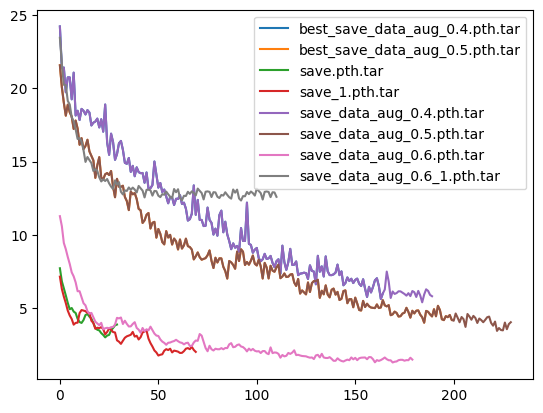

In [ ]:
yolov1_dir=os.path.join(drive_dir,"yolov1")
file_list=list(sorted(os.listdir(yolov1_dir)))
legend=[]
for file in file_list:
  epoch=torch.load(os.path.join(yolov1_dir,file),map_location=torch.device('cpu'))["total_epoch"]
  val_map=torch.load(os.path.join(yolov1_dir,file),map_location=torch.device('cpu'))["mean_loss_array"]
  print(f"File: {file}; Epochs: {epoch}; Val mAP: {min(val_map)}")
  plt.plot(val_map[10:])
  legend.append(file)
  plt.legend(legend)

save_1.pth.tar
File: save_1.pth.tar; Epochs: 80; Val mAP: 0.06299204379320145


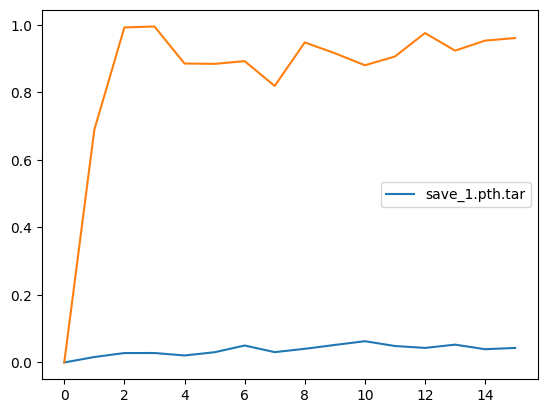

In [ ]:
print(file_list[3])
file=file_list[3]
epoch=torch.load(os.path.join(yolov1_dir,file),map_location=torch.device('cpu'))["total_epoch"]
val_map=torch.load(os.path.join(yolov1_dir,file),map_location=torch.device('cpu'))["map_array_test"]
train_map=torch.load(os.path.join(yolov1_dir,file),map_location=torch.device('cpu'))["map_array_train"]
print(f"File: {file}; Epochs: {epoch}; Val mAP: {max(val_map)}")
plt.plot(val_map)
plt.plot(train_map)
plt.legend([file])

In [ ]:
EPOCHS = 50
MINIMUM_SCALE=0.5
LOAD_MODEL = False
main()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


save_data_aug_0.5
0
img_dir_train: /content/drive/MyDrive/archive/data/yolov8/images/train img_dir_test: /content/drive/MyDrive/archive/data/yolov8/images/val
epoch: 0 Test mAP: 0.0 Train mAP: 0.0
Test mAP Array: [0.0]
Train mAP Array: [0.0]
=> Saving checkpoint


100%|██████████| 25/25 [06:56<00:00, 16.64s/it, loss=40.9]


Mean Loss Array: [110.00563720703126]


100%|██████████| 25/25 [06:43<00:00, 16.12s/it, loss=53.9]


Mean Loss Array: [110.00563720703126, 49.39847999572754]


 68%|██████▊   | 17/25 [04:56<02:19, 17.46s/it, loss=54.7]


KeyboardInterrupt: ignored

In [ ]:
#have to train tiny yolo
EPOCHS = 100
LOAD_MODEL = False
MINIMUM_SCALE=0.3
#main()

save_data_aug_0.6
0
img_dir_train: /content/drive/MyDrive/archive/data/yolov8/images/train img_dir_test: /content/drive/MyDrive/archive/data/yolov8/images/val
epoch: 0 Test mAP: 0.0 Train mAP: 0.0
Test mAP Array: [0.0]
Train mAP Array: [0.0]
=> Saving checkpoint


100%|██████████| 25/25 [00:11<00:00,  2.26it/s, loss=56.6]


Mean Loss Array: [109.72338996887207]


100%|██████████| 25/25 [00:11<00:00,  2.15it/s, loss=84.1]


Mean Loss Array: [109.72338996887207, 44.82798828125]


100%|██████████| 25/25 [00:10<00:00,  2.27it/s, loss=41.2]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076]


100%|██████████| 25/25 [00:11<00:00,  2.11it/s, loss=19.7]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774]


100%|██████████| 25/25 [00:11<00:00,  2.16it/s, loss=12]

Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342]


epoch: 5 Test mAP: 0.0 Train mAP: 0.0747547596693039
Test mAP Array: [0.0, 0.0]
Train mAP Array: [0.0, 0.0747547596693039]
=> Saving checkpoint


100%|██████████| 25/25 [00:10<00:00,  2.32it/s, loss=19.1]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427]


100%|██████████| 25/25 [00:11<00:00,  2.14it/s, loss=19.3]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003]


100%|██████████| 25/25 [00:11<00:00,  2.17it/s, loss=15]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808]


100%|██████████| 25/25 [00:11<00:00,  2.15it/s, loss=12.2]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231]


100%|██████████| 25/25 [00:11<00:00,  2.13it/s, loss=12.3]

Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173]


epoch: 10 Test mAP: 0.02127656154334545 Train mAP: 0.5053293108940125
Test mAP Array: [0.0, 0.0, 0.02127656154334545]
Train mAP Array: [0.0, 0.0747547596693039, 0.5053293108940125]
=> Saving checkpoint


100%|██████████| 25/25 [00:12<00:00,  2.04it/s, loss=10.4]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702]


100%|██████████| 25/25 [00:11<00:00,  2.26it/s, loss=10.5]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475]


100%|██████████| 25/25 [00:10<00:00,  2.33it/s, loss=10.5]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534]


100%|██████████| 25/25 [00:11<00:00,  2.18it/s, loss=7.33]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192]


100%|██████████| 25/25 [00:11<00:00,  2.09it/s, loss=10.2]

Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578]


epoch: 15 Test mAP: 0.010204067453742027 Train mAP: 0.7937700748443604
Test mAP Array: [0.0, 0.0, 0.02127656154334545, 0.010204067453742027]
Train mAP Array: [0.0, 0.0747547596693039, 0.5053293108940125, 0.7937700748443604]
=> Saving checkpoint


100%|██████████| 25/25 [00:11<00:00,  2.12it/s, loss=6.24]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998]


100%|██████████| 25/25 [00:12<00:00,  2.03it/s, loss=9.35]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366]


100%|██████████| 25/25 [00:09<00:00,  2.54it/s, loss=9.68]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148]


100%|██████████| 25/25 [00:11<00:00,  2.09it/s, loss=6.98]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618]


100%|██████████| 25/25 [00:12<00:00,  1.98it/s, loss=6.67]

Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454]


epoch: 20 Test mAP: 0.0051215216517448425 Train mAP: 0.9663692712783813
Test mAP Array: [0.0, 0.0, 0.02127656154334545, 0.010204067453742027, 0.0051215216517448425]
Train mAP Array: [0.0, 0.0747547596693039, 0.5053293108940125, 0.7937700748443604, 0.9663692712783813]
=> Saving checkpoint


100%|██████████| 25/25 [00:11<00:00,  2.15it/s, loss=6.53]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764]


100%|██████████| 25/25 [00:12<00:00,  1.99it/s, loss=5.65]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822]


100%|██████████| 25/25 [00:11<00:00,  2.26it/s, loss=2.98]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698]


100%|██████████| 25/25 [00:10<00:00,  2.40it/s, loss=5.22]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418]


100%|██████████| 25/25 [00:11<00:00,  2.22it/s, loss=4.28]

Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957]


epoch: 25 Test mAP: 0.014166646637022495 Train mAP: 0.9874552488327026
Test mAP Array: [0.0, 0.0, 0.02127656154334545, 0.010204067453742027, 0.0051215216517448425, 0.014166646637022495]
Train mAP Array: [0.0, 0.0747547596693039, 0.5053293108940125, 0.7937700748443604, 0.9663692712783813, 0.9874552488327026]
=> Saving checkpoint


100%|██████████| 25/25 [00:11<00:00,  2.22it/s, loss=5.36]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199]


100%|██████████| 25/25 [00:13<00:00,  1.91it/s, loss=4.36]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186]


100%|██████████| 25/25 [00:11<00:00,  2.10it/s, loss=2.78]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604]


100%|██████████| 25/25 [00:11<00:00,  2.08it/s, loss=3.59]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551]


100%|██████████| 25/25 [00:13<00:00,  1.81it/s, loss=3.41]

Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197]


epoch: 30 Test mAP: 0.03316193446516991 Train mAP: 0.9544763565063477
Test mAP Array: [0.0, 0.0, 0.02127656154334545, 0.010204067453742027, 0.0051215216517448425, 0.014166646637022495, 0.03316193446516991]
Train mAP Array: [0.0, 0.0747547596693039, 0.5053293108940125, 0.7937700748443604, 0.9663692712783813, 0.9874552488327026, 0.9544763565063477]
=> Saving checkpoint


100%|██████████| 25/25 [00:11<00:00,  2.12it/s, loss=4.43]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156]


100%|██████████| 25/25 [00:13<00:00,  1.91it/s, loss=4.4]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967]


100%|██████████| 25/25 [00:10<00:00,  2.47it/s, loss=5.46]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597]


100%|██████████| 25/25 [00:11<00:00,  2.20it/s, loss=2.96]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183]


100%|██████████| 25/25 [00:11<00:00,  2.10it/s, loss=3.71]

Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944]


epoch: 35 Test mAP: 0.003313692519441247 Train mAP: 0.9058959484100342
Test mAP Array: [0.0, 0.0, 0.02127656154334545, 0.010204067453742027, 0.0051215216517448425, 0.014166646637022495, 0.03316193446516991, 0.003313692519441247]
Train mAP Array: [0.0, 0.0747547596693039, 0.5053293108940125, 0.7937700748443604, 0.9663692712783813, 0.9874552488327026, 0.9544763565063477, 0.9058959484100342]
=> Saving checkpoint


100%|██████████| 25/25 [00:10<00:00,  2.38it/s, loss=4.15]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039]


100%|██████████| 25/25 [00:13<00:00,  1.88it/s, loss=3.75]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123]


100%|██████████| 25/25 [00:12<00:00,  2.07it/s, loss=2.01]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483]


100%|██████████| 25/25 [00:12<00:00,  2.04it/s, loss=5.12]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884]


100%|██████████| 25/25 [00:14<00:00,  1.76it/s, loss=10.6]

Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874]


epoch: 40 Test mAP: 0.026041634380817413 Train mAP: 0.7671000361442566
Test mAP Array: [0.0, 0.0, 0.02127656154334545, 0.010204067453742027, 0.0051215216517448425, 0.014166646637022495, 0.03316193446516991, 0.003313692519441247, 0.026041634380817413]
Train mAP Array: [0.0, 0.0747547596693039, 0.5053293108940125, 0.7937700748443604, 0.9663692712783813, 0.9874552488327026, 0.9544763565063477, 0.9058959484100342, 0.7671000361442566]
=> Saving checkpoint


100%|██████████| 25/25 [00:12<00:00,  2.08it/s, loss=2.94]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271]


100%|██████████| 25/25 [00:12<00:00,  2.05it/s, loss=6.59]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017]


100%|██████████| 25/25 [00:10<00:00,  2.48it/s, loss=5.58]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663]


100%|██████████| 25/25 [00:11<00:00,  2.11it/s, loss=4.25]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934]


100%|██████████| 25/25 [00:12<00:00,  2.07it/s, loss=2.44]

Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802]


epoch: 45 Test mAP: 0.0044200788252055645 Train mAP: 0.7827416658401489
Test mAP Array: [0.0, 0.0, 0.02127656154334545, 0.010204067453742027, 0.0051215216517448425, 0.014166646637022495, 0.03316193446516991, 0.003313692519441247, 0.026041634380817413, 0.0044200788252055645]
Train mAP Array: [0.0, 0.0747547596693039, 0.5053293108940125, 0.7937700748443604, 0.9663692712783813, 0.9874552488327026, 0.9544763565063477, 0.9058959484100342, 0.7671000361442566, 0.7827416658401489]
=> Saving checkpoint


100%|██████████| 25/25 [00:12<00:00,  2.06it/s, loss=3.3]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012]


100%|██████████| 25/25 [00:12<00:00,  2.01it/s, loss=3.85]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586]


100%|██████████| 25/25 [00:10<00:00,  2.47it/s, loss=2.89]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082]


100%|██████████| 25/25 [00:11<00:00,  2.27it/s, loss=3.59]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175]


100%|██████████| 25/25 [00:11<00:00,  2.10it/s, loss=2.9]

Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256]


epoch: 50 Test mAP: 0.021867142990231514 Train mAP: 0.8842312693595886
Test mAP Array: [0.0, 0.0, 0.02127656154334545, 0.010204067453742027, 0.0051215216517448425, 0.014166646637022495, 0.03316193446516991, 0.003313692519441247, 0.026041634380817413, 0.0044200788252055645, 0.021867142990231514]
Train mAP Array: [0.0, 0.0747547596693039, 0.5053293108940125, 0.7937700748443604, 0.9663692712783813, 0.9874552488327026, 0.9544763565063477, 0.9058959484100342, 0.7671000361442566, 0.7827416658401489, 0.8842312693595886]
=> Saving checkpoint


100%|██████████| 25/25 [00:12<00:00,  2.06it/s, loss=4.08]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:13<00:00,  1.91it/s, loss=2.27]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:11<00:00,  2.17it/s, loss=2.26]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:10<00:00,  2.31it/s, loss=5.03]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:11<00:00,  2.27it/s, loss=6.22]

Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

epoch: 55 Test mAP: 0.0007518788916058838 Train mAP: 0.8449891209602356
Test mAP Array: [0.0, 0.0, 0.02127656154334545, 0.010204067453742027, 0.0051215216517448425, 0.014166646637022495, 0.03316193446516991, 0.003313692519441247, 0.026041634380817413, 0.0044200788252055645, 0.021867142990231514, 0.0007518788916058838]
Train mAP Array: [0.0, 0.0747547596693039, 0.5053293108940125, 0.7937700748443604, 0.9663692712783813, 0.9874552488327026, 0.9544763565063477, 0.9058959484100342, 0.7671000361442566, 0.7827416658401489, 0.8842312693595886, 0.8449891209602356]
=> Saving checkpoint


100%|██████████| 25/25 [00:11<00:00,  2.19it/s, loss=2.67]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:11<00:00,  2.23it/s, loss=5.95]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:11<00:00,  2.19it/s, loss=4.4]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:11<00:00,  2.11it/s, loss=2.76]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:11<00:00,  2.12it/s, loss=3.4]

Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

epoch: 60 Test mAP: 0.008113626390695572 Train mAP: 0.8830795884132385
Test mAP Array: [0.0, 0.0, 0.02127656154334545, 0.010204067453742027, 0.0051215216517448425, 0.014166646637022495, 0.03316193446516991, 0.003313692519441247, 0.026041634380817413, 0.0044200788252055645, 0.021867142990231514, 0.0007518788916058838, 0.008113626390695572]
Train mAP Array: [0.0, 0.0747547596693039, 0.5053293108940125, 0.7937700748443604, 0.9663692712783813, 0.9874552488327026, 0.9544763565063477, 0.9058959484100342, 0.7671000361442566, 0.7827416658401489, 0.8842312693595886, 0.8449891209602356, 0.8830795884132385]
=> Saving checkpoint


100%|██████████| 25/25 [00:12<00:00,  2.01it/s, loss=4.03]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:12<00:00,  1.92it/s, loss=1.99]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:11<00:00,  2.18it/s, loss=3.14]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:10<00:00,  2.42it/s, loss=2.53]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:11<00:00,  2.19it/s, loss=2.48]

Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

epoch: 65 Test mAP: 0.013275040313601494 Train mAP: 0.9306423664093018
Test mAP Array: [0.0, 0.0, 0.02127656154334545, 0.010204067453742027, 0.0051215216517448425, 0.014166646637022495, 0.03316193446516991, 0.003313692519441247, 0.026041634380817413, 0.0044200788252055645, 0.021867142990231514, 0.0007518788916058838, 0.008113626390695572, 0.013275040313601494]
Train mAP Array: [0.0, 0.0747547596693039, 0.5053293108940125, 0.7937700748443604, 0.9663692712783813, 0.9874552488327026, 0.9544763565063477, 0.9058959484100342, 0.7671000361442566, 0.7827416658401489, 0.8842312693595886, 0.8449891209602356, 0.8830795884132385, 0.9306423664093018]
=> Saving checkpoint


100%|██████████| 25/25 [00:12<00:00,  2.04it/s, loss=2.32]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:12<00:00,  2.02it/s, loss=1.96]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:11<00:00,  2.21it/s, loss=2.54]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:10<00:00,  2.46it/s, loss=2.25]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:11<00:00,  2.18it/s, loss=2.92]

Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

epoch: 70 Test mAP: 0.010353523306548595 Train mAP: 0.8613497614860535
Test mAP Array: [0.0, 0.0, 0.02127656154334545, 0.010204067453742027, 0.0051215216517448425, 0.014166646637022495, 0.03316193446516991, 0.003313692519441247, 0.026041634380817413, 0.0044200788252055645, 0.021867142990231514, 0.0007518788916058838, 0.008113626390695572, 0.013275040313601494, 0.010353523306548595]
Train mAP Array: [0.0, 0.0747547596693039, 0.5053293108940125, 0.7937700748443604, 0.9663692712783813, 0.9874552488327026, 0.9544763565063477, 0.9058959484100342, 0.7671000361442566, 0.7827416658401489, 0.8842312693595886, 0.8449891209602356, 0.8830795884132385, 0.9306423664093018, 0.8613497614860535]
=> Saving checkpoint


100%|██████████| 25/25 [00:12<00:00,  2.05it/s, loss=3.38]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:12<00:00,  2.01it/s, loss=2.05]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:11<00:00,  2.11it/s, loss=3.07]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:11<00:00,  2.09it/s, loss=2.22]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:09<00:00,  2.61it/s, loss=2.71]

Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

epoch: 75 Test mAP: 0.002705624559894204 Train mAP: 0.8504751920700073
Test mAP Array: [0.0, 0.0, 0.02127656154334545, 0.010204067453742027, 0.0051215216517448425, 0.014166646637022495, 0.03316193446516991, 0.003313692519441247, 0.026041634380817413, 0.0044200788252055645, 0.021867142990231514, 0.0007518788916058838, 0.008113626390695572, 0.013275040313601494, 0.010353523306548595, 0.002705624559894204]
Train mAP Array: [0.0, 0.0747547596693039, 0.5053293108940125, 0.7937700748443604, 0.9663692712783813, 0.9874552488327026, 0.9544763565063477, 0.9058959484100342, 0.7671000361442566, 0.7827416658401489, 0.8842312693595886, 0.8449891209602356, 0.8830795884132385, 0.9306423664093018, 0.8613497614860535, 0.8504751920700073]
=> Saving checkpoint


100%|██████████| 25/25 [00:11<00:00,  2.18it/s, loss=2.15]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:11<00:00,  2.20it/s, loss=2.54]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:11<00:00,  2.12it/s, loss=2.47]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:11<00:00,  2.11it/s, loss=1.36]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:11<00:00,  2.12it/s, loss=2.61]

Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

epoch: 80 Test mAP: 0.044328223913908005 Train mAP: 0.8839361667633057
Test mAP Array: [0.0, 0.0, 0.02127656154334545, 0.010204067453742027, 0.0051215216517448425, 0.014166646637022495, 0.03316193446516991, 0.003313692519441247, 0.026041634380817413, 0.0044200788252055645, 0.021867142990231514, 0.0007518788916058838, 0.008113626390695572, 0.013275040313601494, 0.010353523306548595, 0.002705624559894204, 0.044328223913908005]
Train mAP Array: [0.0, 0.0747547596693039, 0.5053293108940125, 0.7937700748443604, 0.9663692712783813, 0.9874552488327026, 0.9544763565063477, 0.9058959484100342, 0.7671000361442566, 0.7827416658401489, 0.8842312693595886, 0.8449891209602356, 0.8830795884132385, 0.9306423664093018, 0.8613497614860535, 0.8504751920700073, 0.8839361667633057]
=> Saving checkpoint


100%|██████████| 25/25 [00:14<00:00,  1.77it/s, loss=1.83]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:12<00:00,  1.96it/s, loss=2.58]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:10<00:00,  2.34it/s, loss=2.66]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:10<00:00,  2.32it/s, loss=2.84]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:12<00:00,  2.06it/s, loss=2.25]

Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

epoch: 85 Test mAP: 0.013353311456739902 Train mAP: 0.9316099286079407
Test mAP Array: [0.0, 0.0, 0.02127656154334545, 0.010204067453742027, 0.0051215216517448425, 0.014166646637022495, 0.03316193446516991, 0.003313692519441247, 0.026041634380817413, 0.0044200788252055645, 0.021867142990231514, 0.0007518788916058838, 0.008113626390695572, 0.013275040313601494, 0.010353523306548595, 0.002705624559894204, 0.044328223913908005, 0.013353311456739902]
Train mAP Array: [0.0, 0.0747547596693039, 0.5053293108940125, 0.7937700748443604, 0.9663692712783813, 0.9874552488327026, 0.9544763565063477, 0.9058959484100342, 0.7671000361442566, 0.7827416658401489, 0.8842312693595886, 0.8449891209602356, 0.8830795884132385, 0.9306423664093018, 0.8613497614860535, 0.8504751920700073, 0.8839361667633057, 0.9316099286079407]
=> Saving checkpoint


100%|██████████| 25/25 [00:12<00:00,  2.01it/s, loss=2.08]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:12<00:00,  1.99it/s, loss=1.77]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:11<00:00,  2.11it/s, loss=3.45]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:10<00:00,  2.34it/s, loss=1.44]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:11<00:00,  2.23it/s, loss=1.78]

Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

epoch: 90 Test mAP: 0.012046190910041332 Train mAP: 0.9345404505729675
Test mAP Array: [0.0, 0.0, 0.02127656154334545, 0.010204067453742027, 0.0051215216517448425, 0.014166646637022495, 0.03316193446516991, 0.003313692519441247, 0.026041634380817413, 0.0044200788252055645, 0.021867142990231514, 0.0007518788916058838, 0.008113626390695572, 0.013275040313601494, 0.010353523306548595, 0.002705624559894204, 0.044328223913908005, 0.013353311456739902, 0.012046190910041332]
Train mAP Array: [0.0, 0.0747547596693039, 0.5053293108940125, 0.7937700748443604, 0.9663692712783813, 0.9874552488327026, 0.9544763565063477, 0.9058959484100342, 0.7671000361442566, 0.7827416658401489, 0.8842312693595886, 0.8449891209602356, 0.8830795884132385, 0.9306423664093018, 0.8613497614860535, 0.8504751920700073, 0.8839361667633057, 0.9316099286079407, 0.9345404505729675]
=> Saving checkpoint


100%|██████████| 25/25 [00:14<00:00,  1.71it/s, loss=3.2]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:13<00:00,  1.91it/s, loss=1.74]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:12<00:00,  2.04it/s, loss=2.11]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:12<00:00,  1.99it/s, loss=3.16]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:12<00:00,  2.02it/s, loss=4.09]

Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

epoch: 95 Test mAP: 0.015503612346947193 Train mAP: 0.8662539124488831
Test mAP Array: [0.0, 0.0, 0.02127656154334545, 0.010204067453742027, 0.0051215216517448425, 0.014166646637022495, 0.03316193446516991, 0.003313692519441247, 0.026041634380817413, 0.0044200788252055645, 0.021867142990231514, 0.0007518788916058838, 0.008113626390695572, 0.013275040313601494, 0.010353523306548595, 0.002705624559894204, 0.044328223913908005, 0.013353311456739902, 0.012046190910041332, 0.015503612346947193]
Train mAP Array: [0.0, 0.0747547596693039, 0.5053293108940125, 0.7937700748443604, 0.9663692712783813, 0.9874552488327026, 0.9544763565063477, 0.9058959484100342, 0.7671000361442566, 0.7827416658401489, 0.8842312693595886, 0.8449891209602356, 0.8830795884132385, 0.9306423664093018, 0.8613497614860535, 0.8504751920700073, 0.8839361667633057, 0.9316099286079407, 0.9345404505729675, 0.8662539124488831]
=> Saving checkpoint


100%|██████████| 25/25 [00:12<00:00,  1.94it/s, loss=3.05]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:13<00:00,  1.89it/s, loss=3.26]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:10<00:00,  2.32it/s, loss=1.85]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:11<00:00,  2.27it/s, loss=2.55]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:12<00:00,  2.02it/s, loss=1.4]

Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

epoch: 100 Test mAP: 0.00856652669608593 Train mAP: 0.8716952204704285
Test mAP Array: [0.0, 0.0, 0.02127656154334545, 0.010204067453742027, 0.0051215216517448425, 0.014166646637022495, 0.03316193446516991, 0.003313692519441247, 0.026041634380817413, 0.0044200788252055645, 0.021867142990231514, 0.0007518788916058838, 0.008113626390695572, 0.013275040313601494, 0.010353523306548595, 0.002705624559894204, 0.044328223913908005, 0.013353311456739902, 0.012046190910041332, 0.015503612346947193, 0.00856652669608593]
Train mAP Array: [0.0, 0.0747547596693039, 0.5053293108940125, 0.7937700748443604, 0.9663692712783813, 0.9874552488327026, 0.9544763565063477, 0.9058959484100342, 0.7671000361442566, 0.7827416658401489, 0.8842312693595886, 0.8449891209602356, 0.8830795884132385, 0.9306423664093018, 0.8613497614860535, 0.8504751920700073, 0.8839361667633057, 0.9316099286079407, 0.9345404505729675, 0.8662539124488831, 0.8716952204704285]
=> Saving checkpoint


100%|██████████| 25/25 [00:13<00:00,  1.80it/s, loss=3.66]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:13<00:00,  1.90it/s, loss=2.44]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:12<00:00,  2.03it/s, loss=1.97]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:11<00:00,  2.13it/s, loss=2.33]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:11<00:00,  2.25it/s, loss=2.07]

Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

epoch: 105 Test mAP: 0.012172631919384003 Train mAP: 0.9339544177055359
Test mAP Array: [0.0, 0.0, 0.02127656154334545, 0.010204067453742027, 0.0051215216517448425, 0.014166646637022495, 0.03316193446516991, 0.003313692519441247, 0.026041634380817413, 0.0044200788252055645, 0.021867142990231514, 0.0007518788916058838, 0.008113626390695572, 0.013275040313601494, 0.010353523306548595, 0.002705624559894204, 0.044328223913908005, 0.013353311456739902, 0.012046190910041332, 0.015503612346947193, 0.00856652669608593, 0.012172631919384003]
Train mAP Array: [0.0, 0.0747547596693039, 0.5053293108940125, 0.7937700748443604, 0.9663692712783813, 0.9874552488327026, 0.9544763565063477, 0.9058959484100342, 0.7671000361442566, 0.7827416658401489, 0.8842312693595886, 0.8449891209602356, 0.8830795884132385, 0.9306423664093018, 0.8613497614860535, 0.8504751920700073, 0.8839361667633057, 0.9316099286079407, 0.9345404505729675, 0.8662539124488831, 0.8716952204704285, 0.9339544177055359]
=> Saving checkpoi

100%|██████████| 25/25 [00:10<00:00,  2.44it/s, loss=2.05]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:12<00:00,  1.93it/s, loss=2.55]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:12<00:00,  1.99it/s, loss=1.43]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:12<00:00,  2.05it/s, loss=2.48]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:12<00:00,  1.98it/s, loss=3.18]

Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

epoch: 110 Test mAP: 0.046446543186903 Train mAP: 0.8891709446907043
Test mAP Array: [0.0, 0.0, 0.02127656154334545, 0.010204067453742027, 0.0051215216517448425, 0.014166646637022495, 0.03316193446516991, 0.003313692519441247, 0.026041634380817413, 0.0044200788252055645, 0.021867142990231514, 0.0007518788916058838, 0.008113626390695572, 0.013275040313601494, 0.010353523306548595, 0.002705624559894204, 0.044328223913908005, 0.013353311456739902, 0.012046190910041332, 0.015503612346947193, 0.00856652669608593, 0.012172631919384003, 0.046446543186903]
Train mAP Array: [0.0, 0.0747547596693039, 0.5053293108940125, 0.7937700748443604, 0.9663692712783813, 0.9874552488327026, 0.9544763565063477, 0.9058959484100342, 0.7671000361442566, 0.7827416658401489, 0.8842312693595886, 0.8449891209602356, 0.8830795884132385, 0.9306423664093018, 0.8613497614860535, 0.8504751920700073, 0.8839361667633057, 0.9316099286079407, 0.9345404505729675, 0.8662539124488831, 0.8716952204704285, 0.9339544177055359, 0.

100%|██████████| 25/25 [00:12<00:00,  1.98it/s, loss=1.52]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:15<00:00,  1.64it/s, loss=1.32]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:12<00:00,  2.08it/s, loss=2.55]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:10<00:00,  2.42it/s, loss=1.36]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:11<00:00,  2.19it/s, loss=2.43]

Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

epoch: 115 Test mAP: 0.017765548080205917 Train mAP: 0.9316245317459106
Test mAP Array: [0.0, 0.0, 0.02127656154334545, 0.010204067453742027, 0.0051215216517448425, 0.014166646637022495, 0.03316193446516991, 0.003313692519441247, 0.026041634380817413, 0.0044200788252055645, 0.021867142990231514, 0.0007518788916058838, 0.008113626390695572, 0.013275040313601494, 0.010353523306548595, 0.002705624559894204, 0.044328223913908005, 0.013353311456739902, 0.012046190910041332, 0.015503612346947193, 0.00856652669608593, 0.012172631919384003, 0.046446543186903, 0.017765548080205917]
Train mAP Array: [0.0, 0.0747547596693039, 0.5053293108940125, 0.7937700748443604, 0.9663692712783813, 0.9874552488327026, 0.9544763565063477, 0.9058959484100342, 0.7671000361442566, 0.7827416658401489, 0.8842312693595886, 0.8449891209602356, 0.8830795884132385, 0.9306423664093018, 0.8613497614860535, 0.8504751920700073, 0.8839361667633057, 0.9316099286079407, 0.9345404505729675, 0.8662539124488831, 0.871695220470428

100%|██████████| 25/25 [00:12<00:00,  2.00it/s, loss=1.44]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:13<00:00,  1.92it/s, loss=1.53]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:12<00:00,  2.07it/s, loss=1.89]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:11<00:00,  2.16it/s, loss=1.63]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:09<00:00,  2.50it/s, loss=1.31]

Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

epoch: 120 Test mAP: 0.023400645703077316 Train mAP: 0.8825041651725769
Test mAP Array: [0.0, 0.0, 0.02127656154334545, 0.010204067453742027, 0.0051215216517448425, 0.014166646637022495, 0.03316193446516991, 0.003313692519441247, 0.026041634380817413, 0.0044200788252055645, 0.021867142990231514, 0.0007518788916058838, 0.008113626390695572, 0.013275040313601494, 0.010353523306548595, 0.002705624559894204, 0.044328223913908005, 0.013353311456739902, 0.012046190910041332, 0.015503612346947193, 0.00856652669608593, 0.012172631919384003, 0.046446543186903, 0.017765548080205917, 0.023400645703077316]
Train mAP Array: [0.0, 0.0747547596693039, 0.5053293108940125, 0.7937700748443604, 0.9663692712783813, 0.9874552488327026, 0.9544763565063477, 0.9058959484100342, 0.7671000361442566, 0.7827416658401489, 0.8842312693595886, 0.8449891209602356, 0.8830795884132385, 0.9306423664093018, 0.8613497614860535, 0.8504751920700073, 0.8839361667633057, 0.9316099286079407, 0.9345404505729675, 0.8662539124488

100%|██████████| 25/25 [00:11<00:00,  2.24it/s, loss=1.82]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:14<00:00,  1.69it/s, loss=2.18]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:12<00:00,  2.03it/s, loss=1.49]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:11<00:00,  2.09it/s, loss=1.29]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:11<00:00,  2.12it/s, loss=1.67]

Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

epoch: 125 Test mAP: 0.01204537134617567 Train mAP: 0.9395813345909119
Test mAP Array: [0.0, 0.0, 0.02127656154334545, 0.010204067453742027, 0.0051215216517448425, 0.014166646637022495, 0.03316193446516991, 0.003313692519441247, 0.026041634380817413, 0.0044200788252055645, 0.021867142990231514, 0.0007518788916058838, 0.008113626390695572, 0.013275040313601494, 0.010353523306548595, 0.002705624559894204, 0.044328223913908005, 0.013353311456739902, 0.012046190910041332, 0.015503612346947193, 0.00856652669608593, 0.012172631919384003, 0.046446543186903, 0.017765548080205917, 0.023400645703077316, 0.01204537134617567]
Train mAP Array: [0.0, 0.0747547596693039, 0.5053293108940125, 0.7937700748443604, 0.9663692712783813, 0.9874552488327026, 0.9544763565063477, 0.9058959484100342, 0.7671000361442566, 0.7827416658401489, 0.8842312693595886, 0.8449891209602356, 0.8830795884132385, 0.9306423664093018, 0.8613497614860535, 0.8504751920700073, 0.8839361667633057, 0.9316099286079407, 0.9345404505729

100%|██████████| 25/25 [00:12<00:00,  2.05it/s, loss=1.25]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:11<00:00,  2.17it/s, loss=1.36]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:11<00:00,  2.27it/s, loss=2.63]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:11<00:00,  2.11it/s, loss=1.27]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:12<00:00,  2.06it/s, loss=1.81]

Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

epoch: 130 Test mAP: 0.016965964809060097 Train mAP: 0.8783979415893555
Test mAP Array: [0.0, 0.0, 0.02127656154334545, 0.010204067453742027, 0.0051215216517448425, 0.014166646637022495, 0.03316193446516991, 0.003313692519441247, 0.026041634380817413, 0.0044200788252055645, 0.021867142990231514, 0.0007518788916058838, 0.008113626390695572, 0.013275040313601494, 0.010353523306548595, 0.002705624559894204, 0.044328223913908005, 0.013353311456739902, 0.012046190910041332, 0.015503612346947193, 0.00856652669608593, 0.012172631919384003, 0.046446543186903, 0.017765548080205917, 0.023400645703077316, 0.01204537134617567, 0.016965964809060097]
Train mAP Array: [0.0, 0.0747547596693039, 0.5053293108940125, 0.7937700748443604, 0.9663692712783813, 0.9874552488327026, 0.9544763565063477, 0.9058959484100342, 0.7671000361442566, 0.7827416658401489, 0.8842312693595886, 0.8449891209602356, 0.8830795884132385, 0.9306423664093018, 0.8613497614860535, 0.8504751920700073, 0.8839361667633057, 0.9316099286

100%|██████████| 25/25 [00:12<00:00,  2.03it/s, loss=0.84]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:12<00:00,  1.94it/s, loss=1.36]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:13<00:00,  1.90it/s, loss=1.34]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:10<00:00,  2.29it/s, loss=1.23]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:12<00:00,  2.07it/s, loss=1.44]

Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

epoch: 135 Test mAP: 0.004761898890137672 Train mAP: 0.9302313923835754
Test mAP Array: [0.0, 0.0, 0.02127656154334545, 0.010204067453742027, 0.0051215216517448425, 0.014166646637022495, 0.03316193446516991, 0.003313692519441247, 0.026041634380817413, 0.0044200788252055645, 0.021867142990231514, 0.0007518788916058838, 0.008113626390695572, 0.013275040313601494, 0.010353523306548595, 0.002705624559894204, 0.044328223913908005, 0.013353311456739902, 0.012046190910041332, 0.015503612346947193, 0.00856652669608593, 0.012172631919384003, 0.046446543186903, 0.017765548080205917, 0.023400645703077316, 0.01204537134617567, 0.016965964809060097, 0.004761898890137672]
Train mAP Array: [0.0, 0.0747547596693039, 0.5053293108940125, 0.7937700748443604, 0.9663692712783813, 0.9874552488327026, 0.9544763565063477, 0.9058959484100342, 0.7671000361442566, 0.7827416658401489, 0.8842312693595886, 0.8449891209602356, 0.8830795884132385, 0.9306423664093018, 0.8613497614860535, 0.8504751920700073, 0.88393616

100%|██████████| 25/25 [00:10<00:00,  2.30it/s, loss=1.37]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:13<00:00,  1.92it/s, loss=1.21]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:11<00:00,  2.13it/s, loss=1.74]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:12<00:00,  2.08it/s, loss=0.811]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:11<00:00,  2.12it/s, loss=1.31]

Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

epoch: 140 Test mAP: 0.019243961200118065 Train mAP: 0.9664768576622009
Test mAP Array: [0.0, 0.0, 0.02127656154334545, 0.010204067453742027, 0.0051215216517448425, 0.014166646637022495, 0.03316193446516991, 0.003313692519441247, 0.026041634380817413, 0.0044200788252055645, 0.021867142990231514, 0.0007518788916058838, 0.008113626390695572, 0.013275040313601494, 0.010353523306548595, 0.002705624559894204, 0.044328223913908005, 0.013353311456739902, 0.012046190910041332, 0.015503612346947193, 0.00856652669608593, 0.012172631919384003, 0.046446543186903, 0.017765548080205917, 0.023400645703077316, 0.01204537134617567, 0.016965964809060097, 0.004761898890137672, 0.019243961200118065]
Train mAP Array: [0.0, 0.0747547596693039, 0.5053293108940125, 0.7937700748443604, 0.9663692712783813, 0.9874552488327026, 0.9544763565063477, 0.9058959484100342, 0.7671000361442566, 0.7827416658401489, 0.8842312693595886, 0.8449891209602356, 0.8830795884132385, 0.9306423664093018, 0.8613497614860535, 0.850475

100%|██████████| 25/25 [00:11<00:00,  2.08it/s, loss=1.89]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:12<00:00,  1.98it/s, loss=3.91]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:10<00:00,  2.48it/s, loss=1.62]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:14<00:00,  1.73it/s, loss=1.76]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:12<00:00,  2.08it/s, loss=3.39]

Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

epoch: 145 Test mAP: 0.01944098062813282 Train mAP: 0.9243113398551941
Test mAP Array: [0.0, 0.0, 0.02127656154334545, 0.010204067453742027, 0.0051215216517448425, 0.014166646637022495, 0.03316193446516991, 0.003313692519441247, 0.026041634380817413, 0.0044200788252055645, 0.021867142990231514, 0.0007518788916058838, 0.008113626390695572, 0.013275040313601494, 0.010353523306548595, 0.002705624559894204, 0.044328223913908005, 0.013353311456739902, 0.012046190910041332, 0.015503612346947193, 0.00856652669608593, 0.012172631919384003, 0.046446543186903, 0.017765548080205917, 0.023400645703077316, 0.01204537134617567, 0.016965964809060097, 0.004761898890137672, 0.019243961200118065, 0.01944098062813282]
Train mAP Array: [0.0, 0.0747547596693039, 0.5053293108940125, 0.7937700748443604, 0.9663692712783813, 0.9874552488327026, 0.9544763565063477, 0.9058959484100342, 0.7671000361442566, 0.7827416658401489, 0.8842312693595886, 0.8449891209602356, 0.8830795884132385, 0.9306423664093018, 0.861349

100%|██████████| 25/25 [00:12<00:00,  2.03it/s, loss=1.42]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:12<00:00,  1.95it/s, loss=2.24]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:09<00:00,  2.52it/s, loss=1.1]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:11<00:00,  2.09it/s, loss=1.39]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:12<00:00,  2.07it/s, loss=1.71]

Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

epoch: 150 Test mAP: 0.010200467891991138 Train mAP: 0.9493480920791626
Test mAP Array: [0.0, 0.0, 0.02127656154334545, 0.010204067453742027, 0.0051215216517448425, 0.014166646637022495, 0.03316193446516991, 0.003313692519441247, 0.026041634380817413, 0.0044200788252055645, 0.021867142990231514, 0.0007518788916058838, 0.008113626390695572, 0.013275040313601494, 0.010353523306548595, 0.002705624559894204, 0.044328223913908005, 0.013353311456739902, 0.012046190910041332, 0.015503612346947193, 0.00856652669608593, 0.012172631919384003, 0.046446543186903, 0.017765548080205917, 0.023400645703077316, 0.01204537134617567, 0.016965964809060097, 0.004761898890137672, 0.019243961200118065, 0.01944098062813282, 0.010200467891991138]
Train mAP Array: [0.0, 0.0747547596693039, 0.5053293108940125, 0.7937700748443604, 0.9663692712783813, 0.9874552488327026, 0.9544763565063477, 0.9058959484100342, 0.7671000361442566, 0.7827416658401489, 0.8842312693595886, 0.8449891209602356, 0.8830795884132385, 0.930

100%|██████████| 25/25 [00:12<00:00,  1.97it/s, loss=0.761]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:13<00:00,  1.91it/s, loss=1.54]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:11<00:00,  2.24it/s, loss=1.35]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:10<00:00,  2.30it/s, loss=1.49]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:13<00:00,  1.86it/s, loss=1.11]

Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

epoch: 155 Test mAP: 0.012091489508748055 Train mAP: 0.9842320084571838
Test mAP Array: [0.0, 0.0, 0.02127656154334545, 0.010204067453742027, 0.0051215216517448425, 0.014166646637022495, 0.03316193446516991, 0.003313692519441247, 0.026041634380817413, 0.0044200788252055645, 0.021867142990231514, 0.0007518788916058838, 0.008113626390695572, 0.013275040313601494, 0.010353523306548595, 0.002705624559894204, 0.044328223913908005, 0.013353311456739902, 0.012046190910041332, 0.015503612346947193, 0.00856652669608593, 0.012172631919384003, 0.046446543186903, 0.017765548080205917, 0.023400645703077316, 0.01204537134617567, 0.016965964809060097, 0.004761898890137672, 0.019243961200118065, 0.01944098062813282, 0.010200467891991138, 0.012091489508748055]
Train mAP Array: [0.0, 0.0747547596693039, 0.5053293108940125, 0.7937700748443604, 0.9663692712783813, 0.9874552488327026, 0.9544763565063477, 0.9058959484100342, 0.7671000361442566, 0.7827416658401489, 0.8842312693595886, 0.8449891209602356, 0.8

100%|██████████| 25/25 [00:12<00:00,  1.95it/s, loss=1.14]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:12<00:00,  1.93it/s, loss=1.37]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:12<00:00,  2.05it/s, loss=1.59]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:11<00:00,  2.21it/s, loss=1.55]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:11<00:00,  2.27it/s, loss=2.11]

Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

epoch: 160 Test mAP: 0.009374989196658134 Train mAP: 0.96986985206604
Test mAP Array: [0.0, 0.0, 0.02127656154334545, 0.010204067453742027, 0.0051215216517448425, 0.014166646637022495, 0.03316193446516991, 0.003313692519441247, 0.026041634380817413, 0.0044200788252055645, 0.021867142990231514, 0.0007518788916058838, 0.008113626390695572, 0.013275040313601494, 0.010353523306548595, 0.002705624559894204, 0.044328223913908005, 0.013353311456739902, 0.012046190910041332, 0.015503612346947193, 0.00856652669608593, 0.012172631919384003, 0.046446543186903, 0.017765548080205917, 0.023400645703077316, 0.01204537134617567, 0.016965964809060097, 0.004761898890137672, 0.019243961200118065, 0.01944098062813282, 0.010200467891991138, 0.012091489508748055, 0.009374989196658134]
Train mAP Array: [0.0, 0.0747547596693039, 0.5053293108940125, 0.7937700748443604, 0.9663692712783813, 0.9874552488327026, 0.9544763565063477, 0.9058959484100342, 0.7671000361442566, 0.7827416658401489, 0.8842312693595886, 0.8

100%|██████████| 25/25 [00:11<00:00,  2.14it/s, loss=1.42]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:12<00:00,  1.98it/s, loss=2.59]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:11<00:00,  2.11it/s, loss=2.12]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:11<00:00,  2.14it/s, loss=2.11]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:10<00:00,  2.44it/s, loss=1.31]

Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

epoch: 165 Test mAP: 0.018000558018684387 Train mAP: 0.9673581719398499
Test mAP Array: [0.0, 0.0, 0.02127656154334545, 0.010204067453742027, 0.0051215216517448425, 0.014166646637022495, 0.03316193446516991, 0.003313692519441247, 0.026041634380817413, 0.0044200788252055645, 0.021867142990231514, 0.0007518788916058838, 0.008113626390695572, 0.013275040313601494, 0.010353523306548595, 0.002705624559894204, 0.044328223913908005, 0.013353311456739902, 0.012046190910041332, 0.015503612346947193, 0.00856652669608593, 0.012172631919384003, 0.046446543186903, 0.017765548080205917, 0.023400645703077316, 0.01204537134617567, 0.016965964809060097, 0.004761898890137672, 0.019243961200118065, 0.01944098062813282, 0.010200467891991138, 0.012091489508748055, 0.009374989196658134, 0.018000558018684387]
Train mAP Array: [0.0, 0.0747547596693039, 0.5053293108940125, 0.7937700748443604, 0.9663692712783813, 0.9874552488327026, 0.9544763565063477, 0.9058959484100342, 0.7671000361442566, 0.7827416658401489,

100%|██████████| 25/25 [00:10<00:00,  2.33it/s, loss=2.52]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:12<00:00,  2.07it/s, loss=1.74]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:12<00:00,  2.08it/s, loss=2.02]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:12<00:00,  2.08it/s, loss=1.24]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:11<00:00,  2.14it/s, loss=1.01]

Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

epoch: 170 Test mAP: 0.01932452619075775 Train mAP: 0.9706774950027466
Test mAP Array: [0.0, 0.0, 0.02127656154334545, 0.010204067453742027, 0.0051215216517448425, 0.014166646637022495, 0.03316193446516991, 0.003313692519441247, 0.026041634380817413, 0.0044200788252055645, 0.021867142990231514, 0.0007518788916058838, 0.008113626390695572, 0.013275040313601494, 0.010353523306548595, 0.002705624559894204, 0.044328223913908005, 0.013353311456739902, 0.012046190910041332, 0.015503612346947193, 0.00856652669608593, 0.012172631919384003, 0.046446543186903, 0.017765548080205917, 0.023400645703077316, 0.01204537134617567, 0.016965964809060097, 0.004761898890137672, 0.019243961200118065, 0.01944098062813282, 0.010200467891991138, 0.012091489508748055, 0.009374989196658134, 0.018000558018684387, 0.01932452619075775]
Train mAP Array: [0.0, 0.0747547596693039, 0.5053293108940125, 0.7937700748443604, 0.9663692712783813, 0.9874552488327026, 0.9544763565063477, 0.9058959484100342, 0.7671000361442566,

100%|██████████| 25/25 [00:12<00:00,  2.06it/s, loss=1.72]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:12<00:00,  2.03it/s, loss=1.25]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:10<00:00,  2.33it/s, loss=1.39]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:12<00:00,  1.99it/s, loss=2.26]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:11<00:00,  2.09it/s, loss=1.62]

Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

epoch: 175 Test mAP: 0.0331081748008728 Train mAP: 0.9686717391014099
Test mAP Array: [0.0, 0.0, 0.02127656154334545, 0.010204067453742027, 0.0051215216517448425, 0.014166646637022495, 0.03316193446516991, 0.003313692519441247, 0.026041634380817413, 0.0044200788252055645, 0.021867142990231514, 0.0007518788916058838, 0.008113626390695572, 0.013275040313601494, 0.010353523306548595, 0.002705624559894204, 0.044328223913908005, 0.013353311456739902, 0.012046190910041332, 0.015503612346947193, 0.00856652669608593, 0.012172631919384003, 0.046446543186903, 0.017765548080205917, 0.023400645703077316, 0.01204537134617567, 0.016965964809060097, 0.004761898890137672, 0.019243961200118065, 0.01944098062813282, 0.010200467891991138, 0.012091489508748055, 0.009374989196658134, 0.018000558018684387, 0.01932452619075775, 0.0331081748008728]
Train mAP Array: [0.0, 0.0747547596693039, 0.5053293108940125, 0.7937700748443604, 0.9663692712783813, 0.9874552488327026, 0.9544763565063477, 0.9058959484100342, 

100%|██████████| 25/25 [00:14<00:00,  1.75it/s, loss=1.53]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:12<00:00,  2.01it/s, loss=1.46]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:11<00:00,  2.11it/s, loss=1.52]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:11<00:00,  2.14it/s, loss=1.79]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:10<00:00,  2.37it/s, loss=0.89]

Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

epoch: 180 Test mAP: 0.024309316650032997 Train mAP: 0.9412909746170044
Test mAP Array: [0.0, 0.0, 0.02127656154334545, 0.010204067453742027, 0.0051215216517448425, 0.014166646637022495, 0.03316193446516991, 0.003313692519441247, 0.026041634380817413, 0.0044200788252055645, 0.021867142990231514, 0.0007518788916058838, 0.008113626390695572, 0.013275040313601494, 0.010353523306548595, 0.002705624559894204, 0.044328223913908005, 0.013353311456739902, 0.012046190910041332, 0.015503612346947193, 0.00856652669608593, 0.012172631919384003, 0.046446543186903, 0.017765548080205917, 0.023400645703077316, 0.01204537134617567, 0.016965964809060097, 0.004761898890137672, 0.019243961200118065, 0.01944098062813282, 0.010200467891991138, 0.012091489508748055, 0.009374989196658134, 0.018000558018684387, 0.01932452619075775, 0.0331081748008728, 0.024309316650032997]
Train mAP Array: [0.0, 0.0747547596693039, 0.5053293108940125, 0.7937700748443604, 0.9663692712783813, 0.9874552488327026, 0.95447635650634

100%|██████████| 25/25 [00:10<00:00,  2.30it/s, loss=2.28]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:12<00:00,  2.04it/s, loss=0.893]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:12<00:00,  2.07it/s, loss=1.88]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:12<00:00,  2.05it/s, loss=1.16]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:11<00:00,  2.09it/s, loss=2.3]

Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

epoch: 185 Test mAP: 0.0389508455991745 Train mAP: 0.9409541487693787
Test mAP Array: [0.0, 0.0, 0.02127656154334545, 0.010204067453742027, 0.0051215216517448425, 0.014166646637022495, 0.03316193446516991, 0.003313692519441247, 0.026041634380817413, 0.0044200788252055645, 0.021867142990231514, 0.0007518788916058838, 0.008113626390695572, 0.013275040313601494, 0.010353523306548595, 0.002705624559894204, 0.044328223913908005, 0.013353311456739902, 0.012046190910041332, 0.015503612346947193, 0.00856652669608593, 0.012172631919384003, 0.046446543186903, 0.017765548080205917, 0.023400645703077316, 0.01204537134617567, 0.016965964809060097, 0.004761898890137672, 0.019243961200118065, 0.01944098062813282, 0.010200467891991138, 0.012091489508748055, 0.009374989196658134, 0.018000558018684387, 0.01932452619075775, 0.0331081748008728, 0.024309316650032997, 0.0389508455991745]
Train mAP Array: [0.0, 0.0747547596693039, 0.5053293108940125, 0.7937700748443604, 0.9663692712783813, 0.9874552488327026

100%|██████████| 25/25 [00:13<00:00,  1.86it/s, loss=1.36]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:13<00:00,  1.85it/s, loss=1.66]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:11<00:00,  2.12it/s, loss=1.96]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:10<00:00,  2.28it/s, loss=1.3]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

100%|██████████| 25/25 [00:10<00:00,  2.32it/s, loss=1.25]

Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

epoch: 190 Test mAP: 0.021965913474559784 Train mAP: 0.9699730277061462
Test mAP Array: [0.0, 0.0, 0.02127656154334545, 0.010204067453742027, 0.0051215216517448425, 0.014166646637022495, 0.03316193446516991, 0.003313692519441247, 0.026041634380817413, 0.0044200788252055645, 0.021867142990231514, 0.0007518788916058838, 0.008113626390695572, 0.013275040313601494, 0.010353523306548595, 0.002705624559894204, 0.044328223913908005, 0.013353311456739902, 0.012046190910041332, 0.015503612346947193, 0.00856652669608593, 0.012172631919384003, 0.046446543186903, 0.017765548080205917, 0.023400645703077316, 0.01204537134617567, 0.016965964809060097, 0.004761898890137672, 0.019243961200118065, 0.01944098062813282, 0.010200467891991138, 0.012091489508748055, 0.009374989196658134, 0.018000558018684387, 0.01932452619075775, 0.0331081748008728, 0.024309316650032997, 0.0389508455991745, 0.021965913474559784]
Train mAP Array: [0.0, 0.0747547596693039, 0.5053293108940125, 0.7937700748443604, 0.966369271278

100%|██████████| 25/25 [00:11<00:00,  2.10it/s, loss=1.71]


Mean Loss Array: [109.72338996887207, 44.82798828125, 32.273617362976076, 26.064711532592774, 21.157442321777342, 19.115713691711427, 16.144016456604003, 14.384355735778808, 13.049383049011231, 12.153732318878173, 11.268043804168702, 10.582560024261475, 9.440228748321534, 9.014247779846192, 8.482091827392578, 8.003567943572998, 7.432519369125366, 7.155730819702148, 6.746190195083618, 6.142616205215454, 6.142941875457764, 5.743178958892822, 5.321213102340698, 5.176215934753418, 4.775535774230957, 4.601470146179199, 4.661863927841186, 4.357816190719604, 4.063107490539551, 3.9366776371002197, 3.8242201232910156, 3.982276134490967, 3.5431699085235597, 3.6115941429138183, 3.6431439113616944, 3.610076675415039, 3.685580883026123, 3.7001155853271483, 3.8652588748931884, 4.324375524520874, 4.284564528465271, 4.347878742218017, 3.902965383529663, 4.126591539382934, 3.909240999221802, 3.7352996635437012, 3.7414236068725586, 3.9067931318283082, 4.026785469055175, 3.6361935329437256, 3.51523427009

 24%|██▍       | 6/25 [00:03<00:11,  1.69it/s, loss=0.74]

In [ ]:
mean_loss_tiny=(torch.load("/content/drive/MyDrive/data/tiny_yolo/save_data_aug_0.6.pth.tar")["mean_loss_array"])
mean_loss_yolo=(torch.load("/content/drive/MyDrive/data/yolov1/save.pth.tar")["mean_loss_array"])
mean_loss_yolo_data=(torch.load("/content/drive/MyDrive/data/yolov1/save_data_aug_0.6.pth.tar")["mean_loss_array"])
form(mean_loss_tiny[:50])
form(mean_loss_yolo[:50])
form(mean_loss_yolo_data[:50])
y = mean_loss[10:]
y2=mean_loss_data_aug[10:]
x = range(max(len(y),len(y2)))
plt.plot(x, y,y2)
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.show()
print(mean_loss_data_aug)
print(mean_loss)

In [ ]:
#map_array_test_data_aug=(torch.load("/content/drive/MyDrive/archive/data/tiny_yolo/save.pth.tar")["map_array_test"])
map_array_test=(torch.load("/content/drive/MyDrive/archive/data/yolov1/best_model.pth.tar")["map_array_test"])
y = map_array_test[0:]
y2=map_array_test_data_aug[0:]
x = range(max(len(y),len(y2)))
plt.plot(x, y,y2)
plt.xlabel('epochs')
plt.ylabel('mAP Test')
plt.title('mAP Test')
plt.show()
print(map_array_test_data_aug)
print(map_array_test)

KeyError: ignored

In [ ]:
map_array_train_tiny_data_aug=(torch.load("/content/drive/MyDrive/data/tiny_yolo/save_data_aug_0.6.pth.tar")["map_array_train"])
map_array_train_data_aug=(torch.load("/content/drive/MyDrive/data/yolov1/save_data_aug_0.6.pth.tar")["map_array_train"])
map_array_train=mean_loss_array=(torch.load("/content/drive/MyDrive/data/yolov1/save.pth.tar")["map_array_train"])
y = map_array_train[0:]
y2=map_array_train_data_aug[0:]
y3=map_array_train_tiny_data_aug
m=min(len(y),len(y2))
x = range(m)
plt.plot(x, y[:m],y)
plt.xlabel('epochs')
plt.ylabel('mAP Train')
plt.title('mAP Train')
plt.show()
print(y3)
print(y)

In [ ]:
def form(array):
  print(', '.join(f'{q:.2f}' for q in array))
# importing the required module
import matplotlib.pyplot as plt
# map_array_train=mean_loss_array=(torch.load("/content/drive/MyDrive/data/yolov1/save.pth.tar")["map_array_train"])
# map_array_test=mean_loss_array=(torch.load("/content/drive/MyDrive/data/yolov1/save.pth.tar")["map_array_test"])
# map_array_train_tiny_data_aug=(torch.load("/content/drive/MyDrive/data/tiny_yolo/save_data_aug_0.6.pth.tar")["map_array_train"])
# map_array_train_data_aug=(torch.load("/content/drive/MyDrive/data/yolov1/save_data_aug_0.6.pth.tar")["map_array_train"])
# map_array_train=mean_loss_array=(torch.load("/content/drive/MyDrive/data/yolov1/save.pth.tar")["map_array_train"])

# map_array_test_data_aug=(torch.load("/content/drive/MyDrive/data/tiny_yolo/save_data_aug_0.6.pth.tar")["map_array_test"])

# map_array_test_06=(torch.load("/content/drive/MyDrive/data/yolov1/save_data_aug_0.6.pth.tar")["map_array_test"])
# map_array_test=(torch.load("/content/drive/MyDrive/data/yolov1/save.pth.tar")["map_array_test"])
# print(file_list[0])
# file=file_list[0]
file="/content/drive/MyDrive/archive/data/yolov1/best_save_data_aug_0.3.pth.tar"
# print(yolov1_dir)
epoch=torch.load(os.path.join(file),map_location=torch.device('cpu'))["total_epoch"]
val_map=torch.load(os.path.join(file),map_location=torch.device('cpu'))["map_array_test"]
train_map=torch.load(os.path.join(file),map_location=torch.device('cpu'))["map_array_train"]
train_loss=torch.load(os.path.join(file),map_location=torch.device('cpu'))["mean_loss_array"]
test_loss=torch.load(os.path.join(file),map_location=torch.device('cpu'))["mean_loss_test_array"]

form(train_map)
form(val_map)
# form(train_loss)
# form(test_loss)
#form(map_array_test)
#print((torch.load("/content/drive/MyDrive/data/yolov1/save_data_aug_0.6.pth.tar")["total_epoch"]))





# x axis values
x = range(len(map_array_test))
# corresponding y axis values
y1 = map_array_test
y2 = map_array_train
print(max(map_array_train))
# plotting the points
plt.plot(x, y1, y2)

# naming the x axis
plt.xlabel('epochs')
# naming the y axis
plt.ylabel('Test mAp')

# giving a title to my graph
plt.title('mAP')

# function to show the plot
plt.show()

0.00, 0.00, 0.00, 0.00, 0.02, 0.03, 0.08, 0.09, 0.13, 0.13, 0.14, 0.24, 0.28, 0.25, 0.30, 0.46, 0.48, 0.44, 0.52, 0.56, 0.62, 0.56, 0.64, 0.68, 0.64, 0.73, 0.71, 0.73, 0.74, 0.75, 0.73, 0.77, 0.77, 0.75, 0.73, 0.73, 0.81, 0.77, 0.76, 0.74, 0.84, 0.79, 0.78, 0.81, 0.86, 0.80, 0.79, 0.84, 0.81, 0.87, 0.88, 0.82, 0.81, 0.84, 0.90, 0.88, 0.82, 0.89, 0.89, 0.85, 0.92, 0.85, 0.88, 0.92, 0.90, 0.87, 0.86, 0.89
0.00, 0.01, 0.01, 0.00, 0.01, 0.01, 0.02, 0.03, 0.05, 0.03, 0.05, 0.11, 0.11, 0.09, 0.06, 0.13, 0.11, 0.21, 0.16, 0.19, 0.23, 0.27, 0.27, 0.21, 0.20, 0.28, 0.23, 0.26, 0.33, 0.28, 0.28, 0.31, 0.29, 0.33, 0.31, 0.34, 0.24, 0.40, 0.42, 0.32, 0.33, 0.39, 0.31, 0.42, 0.43, 0.42, 0.32, 0.40, 0.38, 0.48, 0.41, 0.45, 0.44, 0.46, 0.32, 0.55, 0.43, 0.51, 0.49, 0.48, 0.42, 0.47, 0.41, 0.45, 0.43, 0.38, 0.41, 0.42


NameError: ignored

In [ ]:
#map_array_yolov1=(torch.load(yolov1_dir+"/best_model.pth.tar")["map_array"])
map_array_tiny_test=(torch.load(tiny_yolo_dir+"/save.pth.tar")["map_array_test"])
map_array_tiny_train=(torch.load(tiny_yolo_dir+"/save.pth.tar")["map_array_train"])
mean_loss_array=(torch.load(tiny_yolo_dir+"/save.pth.tar")["mean_loss_array"])
# importing the required module
import matplotlib.pyplot as plt

# x axis values
x = range(len(map_array_tiny_test))
# corresponding y axis values
#y = map_array
# plotting the points
#plt.plot(x, map_array_yolov1,map_array_tiny[:len(map_array_yolov1)])
plt.plot(x, map_array_tiny_test,map_array_tiny_train)

# naming the x axis
plt.xlabel('epochs')
# naming the y axis
plt.ylabel('Test mAp')

# giving a title to my graph
plt.title('mAP')

# function to show the plot
plt.show()

In [ ]:
def show_bbox(img,boxes,name,scores=0,color=(0,255,0)):
    #boxes=boxes.astype(int)
    scores=scores
    img=img.copy()
    for box in boxes:
        score=f"{box[1]:.4f}"
        box = box[2:]
        #score=f"{scores[i]:.4f}"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        x=upper_left_x * width
        y=upper_left_y * height
        w=box[2] * width
        h=box[3] * height
        cv2.rectangle(img,(x,y),(w,h),color,2)
        y=box[1]-10 if box[1]-10>10 else box[1]+10
        cv2.putText(img,score,(box[0],y),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)
    plt.imshow(img)
    #plt.savefig(name+".png")

In [ ]:
def plot_image(image, boxes,color,name):
    """Plots predicted bounding boxes on the image"""
    img = np.array(image)
    height, width, _ = img.shape
    for box in boxes:
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        #upper_left_x = box[0] + box[2] / 2
        #upper_left_y = box[1] + box[3] / 2
        x = int((box[0] - (box[2] / 2)) * img.shape[1])
        y = int((box[1] - (box[3] / 2)) * img.shape[0])

        x2 = x + int(box[2] * img.shape[1])
        y2 = y + int(box[3] * img.shape[0])

        cv2.rectangle(img,(x,y),(x2,y2),color,2)
        # rect = patches.Rectangle(
        #     (upper_left_x * width, upper_left_y * height),
        #     box[2] * width, box[3] * height,
        #     linewidth=1, edgecolor=color, facecolor="none",
        # )
    #plt.show()
    #plt.savefig(name+".png")
    img = Image.fromarray(img)
    img.save('/content/drive/MyDrive/archive/data/box_images/'+name+".jpg")

In [ ]:
model = select_model('tiny_yolo')
load_checkpoint(torch.load('/content/drive/MyDrive/archive/data/tiny_yolo/save_data_aug_0.6.pth.tar'), model, optimizer)
result_tiny_yolo=model.predict(split_size=7,num_boxes=2,num_classes=1,source=IMG_DIR_TEST,conf=0.50,iou=0.5)
model = select_model('yolov1')
load_checkpoint(torch.load('/content/drive/MyDrive/archive/data/yolov1/save.pth.tar'), model, optimizer)
result_yolo_v1=model.predict(split_size=7,num_boxes=2,num_classes=1,source=IMG_DIR_TEST,conf=0.40,iou=0.5)
model = select_model('yolov1')
load_checkpoint(torch.load('/content/drive/MyDrive/archive/data/yolov1/save_data_aug_0.6.pth.tar'), model, optimizer)
result_yolo_v1_data=model.predict(split_size=7,num_boxes=2,num_classes=1,source=IMG_DIR_TEST,conf=0.40,iou=0.5)

=> Loading checkpoint


In [ ]:
yolo_v1_data_a=[]
for key in result_yolo_v1_data:
  if len(result_yolo_v1_data[key])>0:
    yolo_v1_data_a.append(key)

In [ ]:
print(yolov1_a)
print(yolov1_a)
print(yolo_v1_data_a)
temp=list(set(yolov1_a).intersection(yolov1_a))
print(temp)
common_image=list(set(temp).intersection(yolo_v1_data_a))
common_image

['vid_4_10000.jpg', 'vid_4_10100.jpg', 'vid_4_10120.jpg', 'vid_4_1040.jpg', 'vid_4_10980.jpg', 'vid_4_11000.jpg', 'vid_4_11240.jpg', 'vid_4_11260.jpg', 'vid_4_11380.jpg', 'vid_4_11880.jpg', 'vid_4_12080.jpg', 'vid_4_12160.jpg', 'vid_4_12200.jpg', 'vid_4_12240.jpg', 'vid_4_12280.jpg', 'vid_4_12300.jpg', 'vid_4_12320.jpg', 'vid_4_12340.jpg', 'vid_4_13620.jpg', 'vid_4_13740.jpg', 'vid_4_13780.jpg', 'vid_4_13840.jpg', 'vid_4_13900.jpg', 'vid_4_13920.jpg', 'vid_4_14360.jpg', 'vid_4_14440.jpg', 'vid_4_14500.jpg', 'vid_4_15040.jpg', 'vid_4_16060.jpg', 'vid_4_16120.jpg', 'vid_4_16180.jpg', 'vid_4_16300.jpg', 'vid_4_16320.jpg', 'vid_4_16400.jpg', 'vid_4_16660.jpg', 'vid_4_16700.jpg', 'vid_4_16720.jpg', 'vid_4_17100.jpg', 'vid_4_17260.jpg', 'vid_4_17320.jpg', 'vid_4_17340.jpg', 'vid_4_17360.jpg', 'vid_4_17540.jpg', 'vid_4_1760.jpg', 'vid_4_1780.jpg', 'vid_4_18360.jpg', 'vid_4_1840.jpg', 'vid_4_1860.jpg', 'vid_4_18860.jpg', 'vid_4_19040.jpg', 'vid_4_19060.jpg', 'vid_4_19740.jpg', 'vid_4_2040.jpg'

['vid_4_16180.jpg',
 'vid_4_21400.jpg',
 'vid_4_17340.jpg',
 'vid_4_6260.jpg',
 'vid_4_8960.jpg',
 'vid_4_12340.jpg',
 'vid_4_11240.jpg',
 'vid_4_8980.jpg',
 'vid_4_1860.jpg',
 'vid_4_21300.jpg',
 'vid_4_22540.jpg',
 'vid_4_1840.jpg',
 'vid_4_12320.jpg',
 'vid_4_3120.jpg',
 'vid_4_12240.jpg',
 'vid_4_26340.jpg',
 'vid_4_9760.jpg',
 'vid_4_12280.jpg',
 'vid_4_18860.jpg',
 'vid_4_12300.jpg',
 'vid_4_26360.jpg',
 'vid_4_26420.jpg',
 'vid_4_3840.jpg',
 'vid_4_9660.jpg',
 'vid_4_1780.jpg',
 'vid_4_9800.jpg',
 'vid_4_22240.jpg',
 'vid_4_19040.jpg',
 'vid_4_6320.jpg',
 'vid_4_8720.jpg',
 'vid_4_700.jpg',
 'vid_4_9560.jpg',
 'vid_4_21480.jpg',
 'vid_4_26440.jpg',
 'vid_4_11380.jpg',
 'vid_4_26400.jpg',
 'vid_4_3360.jpg',
 'vid_4_26460.jpg',
 'vid_4_8220.jpg',
 'vid_4_6200.jpg']

In [ ]:
model = select_model('tiny_yolo')
load_checkpoint(torch.load('/content/drive/MyDrive/archive/data/tiny_yolo/save.pth.tar'), model, optimizer)
result=model.predict(split_size=7,num_boxes=2,num_classes=1,source=IMG_DIR_TEST,conf=0.50,iou=0.5)
print(model.name)
for key in result:
  if len(result[key])>0:
    if key in common_image:
      print(key,result[key])
      img_file_path=os.path.join('/content/',key[:len(key)-4]+'_2.jpg')
      #img_file_path=os.path.join(IMG_DIR_TEST,key)
      img = Image.open(img_file_path)
      img=np.array(img)
      #show_bbox(img, result[key],key[:len(key)-4]+'_tiny_yolo')
      plot_image(img, result[key],[255,255,0],key[:len(key)-4]+'_2')

=> Loading checkpoint
tiny_yolo
vid_4_11240.jpg [[0.0, 0.9515694975852966, 0.8366514444351196, 0.5613628029823303, 0.21049755811691284, 0.1243748813867569]]
vid_4_11380.jpg [[0.0, 0.9292946457862854, 0.8283365964889526, 0.533279299736023, 0.1527283936738968, 0.13837826251983643]]
vid_4_12240.jpg [[0.0, 0.9994096159934998, 0.9435091614723206, 0.5100623369216919, 0.1267310529947281, 0.1334039717912674], [0.0, 0.9745001196861267, 0.5354689955711365, 0.5154989957809448, 0.09407145529985428, 0.07678566873073578]]
vid_4_12280.jpg [[0.0, 0.9910534620285034, 0.37288612127304077, 0.529699444770813, 0.0632127895951271, 0.06264662742614746], [0.0, 0.9806045293807983, 0.6115041971206665, 0.5825032591819763, 0.25911110639572144, 0.1451244354248047]]
vid_4_12300.jpg [[0.0, 0.9957064390182495, 0.3734770119190216, 0.6051849722862244, 0.23762769997119904, 0.12689898908138275], [0.0, 0.9887163043022156, 0.6872126460075378, 0.5500388145446777, 0.2435774803161621, 0.11199448257684708], [0.0, 0.94754457473

In [ ]:
tiny_yolo_data=torch.load('/content/drive/MyDrive/archive/data/tiny_yolo/save_data_aug_0.6.pth.tar')['map_array_test']
yolo_v1=torch.load('/content/drive/MyDrive/archive/data/yolov1/save.pth.tar')['map_array_test']
yolo_v1_data=torch.load('/content/drive/MyDrive/archive/data/yolov1/save_data_aug_0.6.pth.tar')['map_array_test']
print(tiny_yolo_data)
print(yolo_v1)
print(yolo_v1_data)

[0.0, 0.0, 0.031045708805322647, 0.08081141114234924, 0.057424236088991165, 0.1321578323841095, 0.2022007405757904, 0.14842191338539124, 0.14811937510967255, 0.15236008167266846, 0.15277783572673798, 0.19670549035072327, 0.13649199903011322, 0.1618472784757614, 0.19791735708713531, 0.17653010785579681]
[0.0, 0.0, 0.03395633399486542, 0.047404784709215164, 0.06946990638971329, 0.07649116963148117, 0.10722114145755768, 0.10278230160474777, 0.10604818165302277, 0.1036040261387825, 0.10587041079998016, 0.1091078668832779, 0.11508957296609879, 0.1094265729188919, 0.10781236737966537, 0.10372328013181686, 0.0783223882317543, 0.10965558886528015, 0.1077393889427185, 0.10372328013181686, 0.0783223882317543, 0.10965558886528015, 0.1077393889427185, 0.10372328013181686, 0.0783223882317543]
[0.0, 0.0, 0.0, 0.027777742594480515, 0.04140334948897362, 0.058830536901950836, 0.13151617348194122, 0.10589194297790527, 0.13381284475326538, 0.19532249867916107, 0.15895654261112213, 0.15404492616653442, 0.

In [ ]:
tiny_yolo=['vid_4_12240.jpg', 'vid_4_17340.jpg', 'vid_4_17600.jpg', 'vid_4_26320.jpg', 'vid_4_26440.jpg', 'vid_4_26540.jpg', 'vid_4_29960.jpg', 'vid_4_30020.jpg', 'vid_4_3340.jpg', 'vid_4_920.jpg', 'vid_4_9500.jpg', 'vid_4_9540.jpg']
yolo_v1=['vid_4_10960.jpg', 'vid_4_11900.jpg', 'vid_4_12240.jpg', 'vid_4_13660.jpg', 'vid_4_16400.jpg', 'vid_4_16440.jpg', 'vid_4_17340.jpg', 'vid_4_17440.jpg', 'vid_4_17560.jpg', 'vid_4_1760.jpg', 'vid_4_17600.jpg', 'vid_4_17640.jpg', 'vid_4_19040.jpg', 'vid_4_1940.jpg', 'vid_4_2020.jpg', 'vid_4_2060.jpg', 'vid_4_2100.jpg', 'vid_4_21500.jpg', 'vid_4_22220.jpg', 'vid_4_22720.jpg', 'vid_4_2540.jpg', 'vid_4_26320.jpg', 'vid_4_26440.jpg', 'vid_4_26540.jpg', 'vid_4_28240.jpg', 'vid_4_28840.jpg', 'vid_4_29520.jpg', 'vid_4_29960.jpg', 'vid_4_29980.jpg', 'vid_4_30020.jpg', 'vid_4_3340.jpg', 'vid_4_3420.jpg', 'vid_4_3440.jpg', 'vid_4_3520.jpg', 'vid_4_3840.jpg', 'vid_4_6160.jpg', 'vid_4_6360.jpg', 'vid_4_6400.jpg', 'vid_4_8580.jpg', 'vid_4_9020.jpg', 'vid_4_9060.jpg', 'vid_4_920.jpg', 'vid_4_9320.jpg', 'vid_4_9500.jpg', 'vid_4_9520.jpg', 'vid_4_9540.jpg', 'vid_4_9660.jpg', 'vid_4_9780.jpg', 'vid_4_9820.jpg']
yolo_v1_data=['vid_4_12240.jpg', 'vid_4_13660.jpg', 'vid_4_17340.jpg', 'vid_4_17560.jpg', 'vid_4_17600.jpg', 'vid_4_17640.jpg', 'vid_4_19040.jpg', 'vid_4_1940.jpg', 'vid_4_2020.jpg', 'vid_4_2540.jpg', 'vid_4_26320.jpg', 'vid_4_26440.jpg', 'vid_4_29960.jpg', 'vid_4_3340.jpg', 'vid_4_3420.jpg', 'vid_4_3440.jpg', 'vid_4_3840.jpg', 'vid_4_6160.jpg', 'vid_4_920.jpg', 'vid_4_9500.jpg', 'vid_4_9520.jpg', 'vid_4_9540.jpg', 'vid_4_9660.jpg', 'vid_4_9780.jpg']
list(set(['vid_4_26320.jpg',
 'vid_4_17340.jpg',
 'vid_4_30020.jpg',
 'vid_4_12240.jpg',
 'vid_4_9540.jpg',
 'vid_4_26440.jpg',
 'vid_4_26540.jpg',
 'vid_4_920.jpg',
 'vid_4_3340.jpg',
 'vid_4_29960.jpg',
 'vid_4_9500.jpg',
 'vid_4_17600.jpg']).intersection(yolo_v1_data))

In [ ]:
load_checkpoint(torch.load(BEST_MODEL_FILE), model, optimizer)
test_images=drive_dir+'/testing_images'
result_2=model.predict(source=test_images,conf=0.40,iou=0.5,num_boxes=2, num_classes=1,split_size=7)
imgs_name=['vid_5_400.jpg','vid_5_26720.jpg']
for key in result_2:
  if key in imgs_name:
  #if len(result_2[key])>0:
    print(key,result_2[key])
    img_file_path=os.path.join(test_images,key)
    img = Image.open(img_file_path)
    print(img_file_path)
    plot_image(img, result_2[key])

In [ ]:
load_checkpoint(torch.load(BEST_MODEL_FILE), model, optimizer)
for i in range(10):
    pred_boxes, target_boxes = get_bboxes(test_loader, model, iou_threshold=0.5, threshold=0.4, device=DEVICE) #Overfitting
    mean_avg_prec = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")
    print(f"epoch: {epoch} Train mAP: {mean_avg_prec}")

In [ ]:
IMG_DIR_TEST

In [ ]:
def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [ ]:
import torchvision
from torchvision.transforms.v2 import functional as F
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        bboxes=yolotobox(bboxes,F.get_spatial_size(img)[1],F.get_spatial_size(img)[0])
        if not bboxes:
          bboxes.append([0.0,0.0,0.0,0.0])
        bboxes = datapoints.BoundingBox(bboxes,format=datapoints.BoundingBoxFormat.CXCYWH,spatial_size=F.get_spatial_size(img),)
        for t in self.transforms:
            img, bboxes = t(img,bboxes)

        return img, boxtoyolo(bboxes,448,448)

transform = Compose([
      transforms.RandomResizedCrop(size=(448, 448),scale=(0.6,1),ratio=(1,1), antialias=True),
      transforms.RandomHorizontalFlip(p=0.5),



      #transforms.Resize((448, 448)),
      transforms.ToTensor(),
      #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.2, 0.2, 0.2]),
      ])
resize_cropper = transforms.RandomResizedCrop(size=(448, 448))
image_id="vid_4_1000"
orig_img=Image.open('/content/drive/MyDrive/data/yolov8/images/train/'+image_id+'.jpg')
label_path='/content/drive/MyDrive/data/yolov8/labels/train/'+image_id+'.txt'
boxes=[]
if path.exists(label_path) == True:
          with open(label_path) as f:
              for label in f.readlines():
                  class_label, x, y, width, height = [float(x) if float(x)!=int(float(x)) else int(float(x)) for x in label.strip().split()]
                  boxes.append([class_label, x, y, width, height])
boxes= torch.tensor(boxes)
resized_crop=[]
for i in range(6):
  resized,box = transform(orig_img,boxes)
  #print(resized)
  trans=transforms.ToPILImage()
  resized_crop.append(trans(resized))
  #resized_crop.append(resized)
  #print(box[0])
  #print(boxtoyolo(box[0].tolist(),448,448))
  #box=boxtoyolo(box[0].tolist(),448,448)
  #print(box)
  for b in box:
    b.insert(0,0.0)
  print(box)
  plot_image(trans(resized), box)
plot(resized_crop)
#print(yoloboxes([[0.11034732271449704, 0.5591216215789474, 0.17149059332840239, 0.13642213631578948]],F.get_spatial_size(orig_img)[1],F.get_spatial_size(orig_img)[0]))
#print(F.get_spatial_size(orig_img)[1],F.get_spatial_size(orig_img)[0])
